This Notebook is used to experiement with the data for the dashboard and see exactly how it can be displayed

In [172]:
import base64
import time
import requests

def get_all_reviews(professor_id):
    headers = {
        'Authorization': 'Basic dGVzdDp0ZXN0',
        'Content-Type': 'application/json',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Encode the professor_id in base64
    encoded_professor_id = base64.b64encode(f"Teacher-{professor_id}".encode()).decode()
    
    rev_list = []
    has_next_page = True
    end_cursor = None
    
    while has_next_page:
        # Add the after parameter if we have an end cursor
        ratings_params = "first: 1000"
        if end_cursor:
            ratings_params += f', after: "{end_cursor}"'
            
        payload = {
            "query": f"""query GetTeacherRatings($id: ID!) {{
                node(id: $id) {{
                    ... on Teacher {{
                        id firstName lastName
                        school {{ name }}
                        ratings({ratings_params}) {{
                            edges {{
                                node {{
                                    comment class difficultyRating qualityRating
                                    attendanceMandatory wouldTakeAgain
                                    isForCredit textbookUse date grade ratingTags clarityRating
                                    helpfulRating isForOnlineClass thumbsUpTotal thumbsDownTotal
                                }}
                            }}
                            pageInfo {{
                                hasNextPage
                                endCursor
                            }}
                        }}
                    }}
                }}
            }}""",
            "variables": {
                "id": encoded_professor_id
            }
        }
        
        response = requests.post(
            "https://www.ratemyprofessors.com/graphql",
            json=payload,
            headers=headers
        )
        if response.status_code == 429:
            print("Rate limit exceeded, waiting 10 seconds before retrying...")
            time.sleep(10)
            continue

        if response.status_code == 503:
            print("Rate limit exceeded, waiting 10 seconds before retrying...")
            time.sleep(10)
            continue
        
        if response.status_code != 200:
            print(f"Error: Status code {response.status_code}")
            print(response.text)
            return None
            
        data = response.json()
        
        # Check for errors in the response
        if 'errors' in data:
            print("GraphQL Errors:", data['errors'])
            return None
            
        node_list = data['data']['node']['ratings']['edges']
        page_info = data['data']['node']['ratings']['pageInfo']
        
        # Add professor_id to each review and append to results
        for node in node_list:
            node['node']['pid'] = professor_id
            rev_list.append(node['node'])
            
        # Update pagination info
        has_next_page = page_info['hasNextPage']
        end_cursor = page_info['endCursor']
        
        # Add a small delay between requests
        if has_next_page:
            time.sleep(0.5)
    return rev_list


In [173]:
import pandas as pd

reviews = get_all_reviews(1918813)
df = pd.DataFrame(reviews)
display(df)



,attendanceMandatory,clarityRating,class,comment,date,difficultyRating,grade,helpfulRating,isForCredit,isForOnlineClass,qualityRating,ratingTags,textbookUse,thumbsDownTotal,thumbsUpTotal,wouldTakeAgain,pid
0,mandatory,1,BIO152,Condescending when students ask questions. Not...,2025-02-03 20:33:49 +0000 UTC,4,A-,1,True,False,1,Tough grader--Participation matters--Test heavy,-1.000,0,0,NaN,1918813
1,mandatory,5,BIO152,Really great lecturer. Class is super engaging...,2025-01-13 01:05:23 +0000 UTC,2,A,5,True,False,5,Amazing lectures --Clear grading criteria--Hil...,-1.000,0,0,1.000,1918813
2,mandatory,4,BIOLOGY151,Good teacher and helpful in and outside of cla...,2025-01-12 10:37:58 +0000 UTC,4,A-,4,True,False,4,Tough grader--Participation matters--Lecture h...,-1.000,0,0,1.000,1918813
3,non mandatory,5,BIO151,"this class has extensive material, especially ...",2025-01-12 00:32:20 +0000 UTC,2,A,5,True,False,5,Get ready to read--EXTRA CREDIT--Clear grading...,-1.000,0,0,1.000,1918813
4,non mandatory,5,BIO152,Prof. Rounds is an amazing professor! He loves...,2025-01-12 00:29:24 +0000 UTC,2,A,5,True,False,5,EXTRA CREDIT--Clear grading criteria--Caring,-1.000,0,0,1.000,1918813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,,4,BIO151,He is a great professor. The stuff you need to...,2014-10-14 13:27:08 +0000 UTC,3,,5,True,False,5,,5.000,0,1,NaN,1918813
266,non mandatory,2,BIO151,"I took this class because I had to, and I regr...",2014-10-06 18:07:48 +0000 UTC,4,,2,True,False,2,,5.000,0,1,NaN,1918813
267,,1,BIO151,I am taking his bio class as a freshman and am...,2014-09-29 18:56:01 +0000 UTC,4,,3,True,False,2,,5.000,1,2,NaN,1918813
268,,5,BIO151,I love Caleb! He's so funny and makes things m...,2014-09-10 22:06:08 +0000 UTC,3,,5,False,False,5,,5.000,1,1,NaN,1918813


In [174]:
# Remove '+0000 UTC' from date strings and replace with 'UTC'
df['date'] = df['date'].str.replace('+0000 UTC', 'UTC')
df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S UTC')

display(df)


,attendanceMandatory,clarityRating,class,comment,date,difficultyRating,grade,helpfulRating,isForCredit,isForOnlineClass,qualityRating,ratingTags,textbookUse,thumbsDownTotal,thumbsUpTotal,wouldTakeAgain,pid,datetime
0,mandatory,1,BIO152,Condescending when students ask questions. Not...,2025-02-03 20:33:49 UTC,4,A-,1,True,False,1,Tough grader--Participation matters--Test heavy,-1.000,0,0,NaN,1918813,2025-02-03 20:33:49
1,mandatory,5,BIO152,Really great lecturer. Class is super engaging...,2025-01-13 01:05:23 UTC,2,A,5,True,False,5,Amazing lectures --Clear grading criteria--Hil...,-1.000,0,0,1.000,1918813,2025-01-13 01:05:23
2,mandatory,4,BIOLOGY151,Good teacher and helpful in and outside of cla...,2025-01-12 10:37:58 UTC,4,A-,4,True,False,4,Tough grader--Participation matters--Lecture h...,-1.000,0,0,1.000,1918813,2025-01-12 10:37:58
3,non mandatory,5,BIO151,"this class has extensive material, especially ...",2025-01-12 00:32:20 UTC,2,A,5,True,False,5,Get ready to read--EXTRA CREDIT--Clear grading...,-1.000,0,0,1.000,1918813,2025-01-12 00:32:20
4,non mandatory,5,BIO152,Prof. Rounds is an amazing professor! He loves...,2025-01-12 00:29:24 UTC,2,A,5,True,False,5,EXTRA CREDIT--Clear grading criteria--Caring,-1.000,0,0,1.000,1918813,2025-01-12 00:29:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,,4,BIO151,He is a great professor. The stuff you need to...,2014-10-14 13:27:08 UTC,3,,5,True,False,5,,5.000,0,1,NaN,1918813,2014-10-14 13:27:08
266,non mandatory,2,BIO151,"I took this class because I had to, and I regr...",2014-10-06 18:07:48 UTC,4,,2,True,False,2,,5.000,0,1,NaN,1918813,2014-10-06 18:07:48
267,,1,BIO151,I am taking his bio class as a freshman and am...,2014-09-29 18:56:01 UTC,4,,3,True,False,2,,5.000,1,2,NaN,1918813,2014-09-29 18:56:01
268,,5,BIO151,I love Caleb! He's so funny and makes things m...,2014-09-10 22:06:08 UTC,3,,5,False,False,5,,5.000,1,1,NaN,1918813,2014-09-10 22:06:08


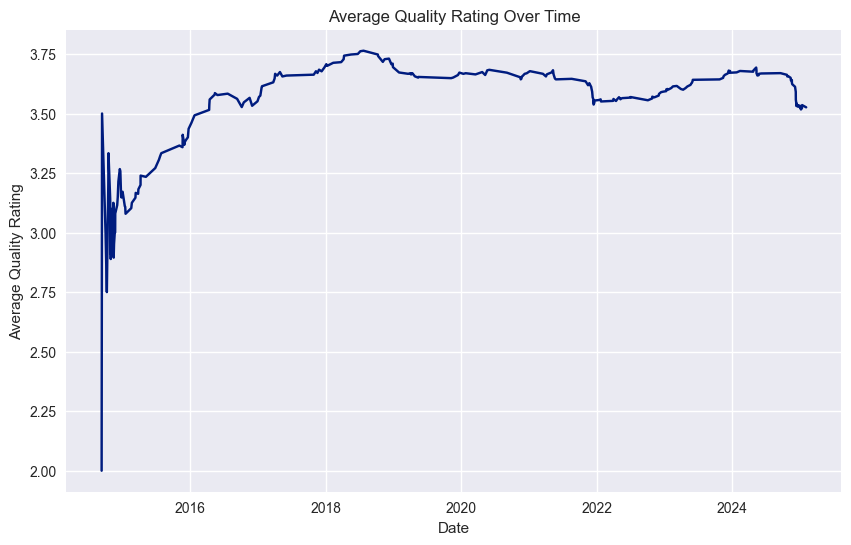

In [175]:
import matplotlib.pyplot as plt

def get_avg_quality_over_time(df):
    df['quality'] = df['qualityRating']
    df = df.sort_values('datetime')
    df['avg_quality'] = df['quality'].expanding().mean()
    return df

avg_quality_over_time = get_avg_quality_over_time(df)



plt.figure(figsize=(10, 6))
plt.plot(avg_quality_over_time['datetime'], avg_quality_over_time['avg_quality'])
plt.xlabel('Date')
plt.ylabel('Average Quality Rating')
plt.title('Average Quality Rating Over Time')
plt.show()

## **Features in the DataFrame**  
**(with Notes on Usefulness)**

- **attendanceMandatory** - ➖ Maybe useful, but lots of nulls  
- **clarityRating** - ❌ Outdated  
- **class** - ➖ Useful for class analysis (maybe in v2 or v3 of the dashboard)  
- **comment** - ✅ Useful  
- **createdByUser** - ❌ Useless  
- **date** - ✅ Time series data  
- **difficultyRating** - ✅ Useful  
- **grade** - ✅ Useful  
- **helpfulRating** - ❌ Outdated, specific to review  
- **isForCredit** - ➖ Maybe useful  
- **isForOnlineClass** - ➖ Maybe useful  
- **qualityRating** - ✅ Useful  
- **ratingTags** - ✅➖ Maybe useful, can show trends because they're standardized  
- **textbookUse** - ➖ Maybe useful  
- **thumbsDownTotal** - Only useful for specific reviews  
- **thumbsUpTotal** - Only useful for specific reviews  
- **wouldTakeAgain** - ✅ Useful  
- **pid** - ❌ Implied data  

---

## **Professor Page Features**

### **V1 (Basic)**
- **Quality rating over time**  
  - (1) Rolling window average  
  - (2) Overall average regardless of date  
- **Difficulty rating over time**  
  - (1) Rolling window average  
  - (2) Overall average regardless of date  
- **Would take again percentage**  
  - (1) Time series  
  - (2) Overall percentage  
- **Attendance mandatory percentage**  
  - (1) Overall percentage  
- **Rating tags distribution**  
  - (1) Overall distribution  
- **Is online**  
  - (1) Overall percentage  
- **Is for credit**  
  - (1) Overall percentage  
- **Comment**  
  - (1) Average comment length  
  - (2) Sentiment analysis  
- **Filter by class** (No analysis, just filter)  
- **Date span and heatmap/bar graph of reviews by date**

### **V2 (Intermediate)**
- **Interaction score**  
  - (Display score) - Something with thumbs ups, thumbs downs, and number of comments  
- **Extractive summary of comments**  
- **Filter by class** (with overall class analysis)  
- **Average grade in class** (Note: may be skewed as reviewers are more likely to be those who did well or terribly)  
- **Review volume trends** (Are reviews increasing or decreasing over time?)  
- **Rating tags distribution**  
  - (1) Make into categories (all options listed on RMP website)  
  - (2) Display over time  
- **Red flags analysis**  
  - Combination of low ratings + specific tags  

### **V3 (Advanced)**
- **Topic summarization**  
  - Use LDA (Latent Dirichlet Allocation) to identify topics  
  - Display topics and the comments associated with them  
- **Seasonal patterns in ratings** (e.g., Fall vs Spring semester comparisons)  
- **Best professors for classes**  
- **AI-generated teaching style summary**

### **V4 (Advanced ML)**
- **Predictive graph of difficulty rating**  
- **Cluster professors by rating and department** (if in top 100 US universities)  
- **Predict school size, rating, etc., from reviews**  
- **Course matching**  
  - Top 100 US universities, combine similar courses  
- **Review authenticity analysis**  
- **Time series prediction**  
- **Recommendation system** (Top 100 US universities)

---

## **Overall Stats - Home Page for Top 100 US Universities** (with Disclaimer)

### **V1 (Basic)**
- **Overall average quality rating**  
- **Overall average difficulty rating**  
- **Overall would take again percentage**  
- **Overall attendance mandatory percentage**  
- **Overall rating tags distribution**  
- **Ratings over time**  
- **Help the user better understand the data they’re viewing**  
- **Look at Preprocess & EDA for more ideas**

### **V2 (Intermediate)**
- **Department-level comparisons across universities**  
- **Gender analysis in ratings** (Generate by guess of first name)  
- **Course level distribution** (Intro vs advanced courses)  
- **Online vs In-person teaching effectiveness**  
- **University ranking correlation with ratings**  
- **Seasonal trends across universities**
- **Apply original overall to university page**


### **V3 (Advanced)**
- **Geographic analysis of rating patterns**  
- **Class size impact on ratings**  
- **Teaching experience correlation with ratings**  
- **Department-specific rating patterns**  
- **Rank universities by overall rating and other factors**

### **V4 (Advanced ML)**
- **Predictive graph of difficulty rating**  
- **Cluster professors by rating and department** (if in top 100 US universities)  
- **Predict school size, rating, etc., from reviews**  
- **Course matching**  
  - Top 100 US universities, combine similar courses  
- **Review authenticity analysis**  
- **Time series prediction**  
- **Recommendation system** (Top 100 US universities)


## V(1)

### Professors
- **Quality rating over time**  
  - (1) Rolling window average  
  - (2) Overall average regardless of date  
- **Difficulty rating over time**  
  - (1) Rolling window average  
  - (2) Overall average regardless of date  
- **Would take again percentage**  
  - (1) Time series (Possible addition: rolling?)
  - (2) Overall percentage  
- **Attendance mandatory percentage**  
  - (1) Overall percentage  
  - Addition: (2) By year
- **Rating tags distribution**  
  - (1) Overall distribution  
- **Is online**  
  - (1) Overall percentage  
- **Is for credit**  
  - (1) Overall percentage  
- **Comment**  
  - (1) Average comment length  
  - (2) Sentiment analysis  
- **Filter by class** (No analysis, just filter)  
- **Date span and heatmap/bar graph of reviews by date**

### Overall
- **Overall average quality rating**  
- **Overall average difficulty rating**  
- **Overall would take again percentage**  
- **Overall attendance mandatory percentage**  
- **Overall rating tags distribution**  
- **Ratings over time**  
- **Help the user better understand the data they’re viewing**  
- **Look at Preprocess & EDA for more ideas**

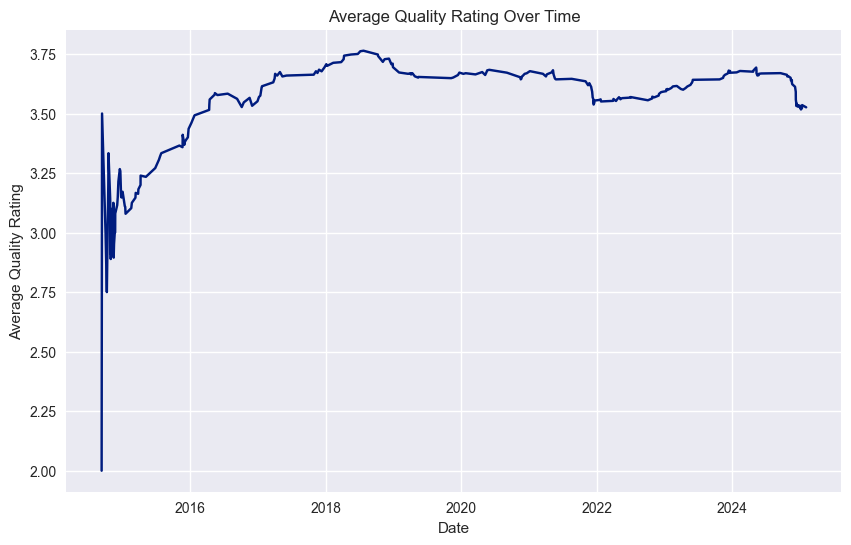

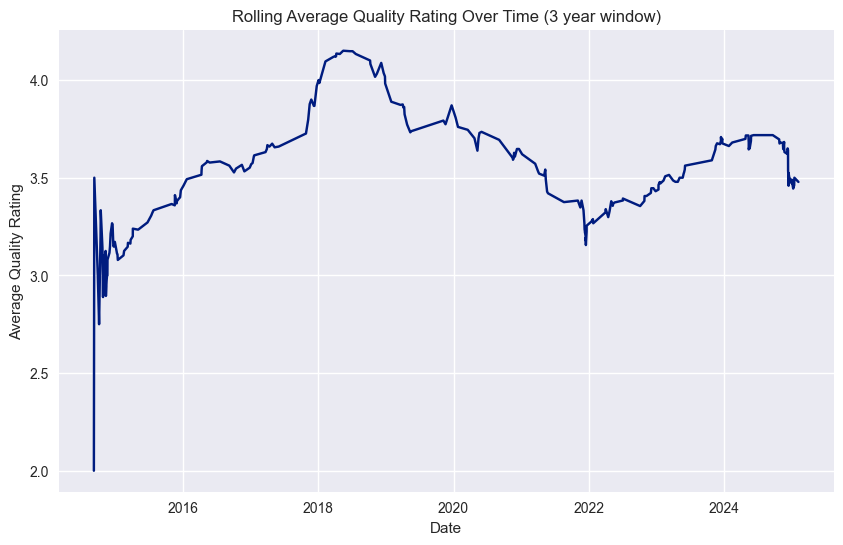

In [176]:
# Quality Rating over time
def avg_quality_rating(df):
    df = df.sort_values('datetime')
    df['avg_quality'] = df['qualityRating'].expanding().mean()
    return df[['datetime', 'avg_quality']]

avg_quality = avg_quality_rating(df)

plt.figure(figsize=(10, 6))
plt.plot(avg_quality_over_time['datetime'], avg_quality_over_time['avg_quality'])
plt.xlabel('Date')
plt.ylabel('Average Quality Rating')
plt.title('Average Quality Rating Over Time')
plt.show()
    
def rolling_avg_quality_rating(df, window_years=3):
    window_days = f"{365 * window_years}D"
    df = df.sort_values('datetime')
    # Calculate 3-year rolling average (assuming 365*3 days window)
    df = df.set_index('datetime') # Set datetime as index
    df['rolling_avg_quality'] = df['qualityRating'].rolling(window=window_days, min_periods=1).mean() # Calculate rolling average
    df = df.reset_index() # Reset index
    return df[['datetime', 'rolling_avg_quality']]

rolling_quality = rolling_avg_quality_rating(df)

plt.figure(figsize=(10, 6))
plt.plot(avg_quality_over_time['datetime'], rolling_quality['rolling_avg_quality'])
plt.xlabel('Date')
plt.ylabel('Average Quality Rating')
plt.title('Rolling Average Quality Rating Over Time (3 year window)')
plt.show()


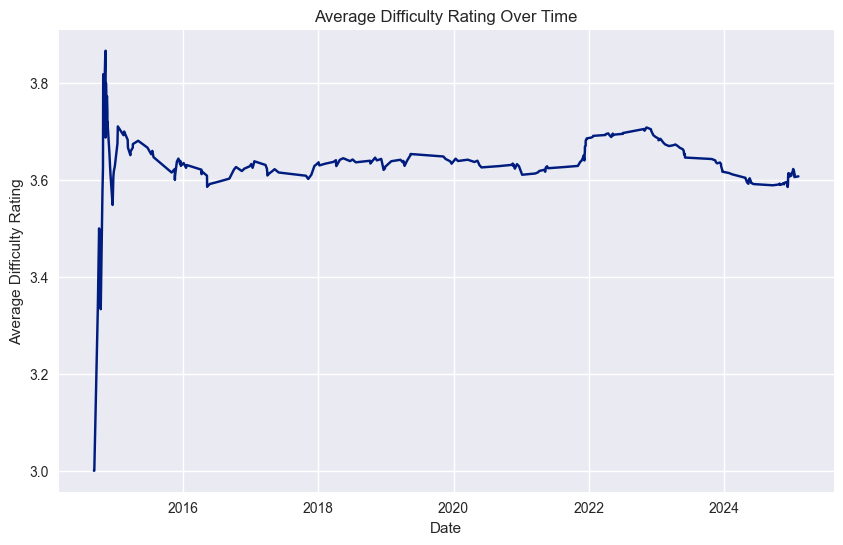

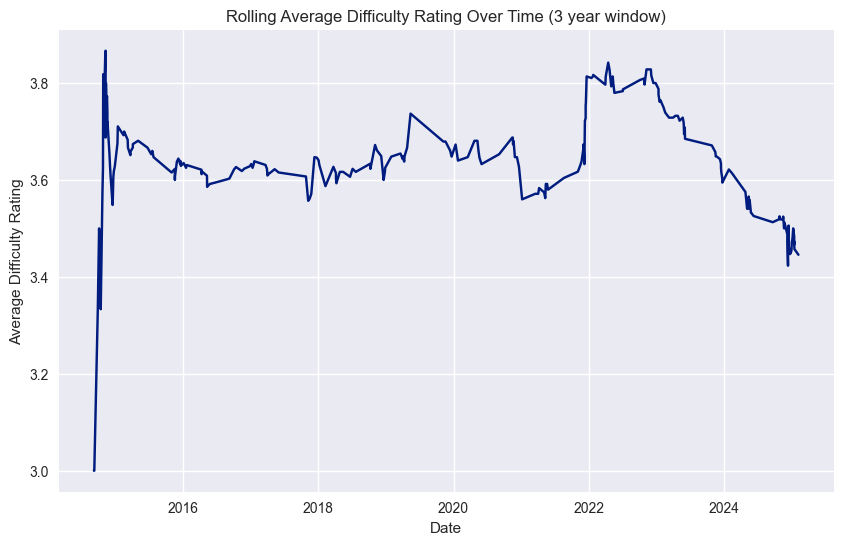

In [177]:
# Difficulty Rating over time
def avg_difficulty_rating(df):
    df = df.sort_values('datetime')
    df['avg_difficulty'] = df['difficultyRating'].expanding().mean()
    return df[['datetime', 'avg_difficulty']]

avg_difficulty = avg_difficulty_rating(df)

plt.figure(figsize=(10, 6))
plt.plot(avg_difficulty['datetime'], avg_difficulty['avg_difficulty'])
plt.xlabel('Date')
plt.ylabel('Average Difficulty Rating')
plt.title('Average Difficulty Rating Over Time')
plt.show()
    
def rolling_avg_difficulty_rating(df, window_years=3):
    window_days = f"{365 * window_years}D"
    df = df.sort_values('datetime')
    # Calculate 3-year rolling average (assuming 365*3 days window)
    df = df.set_index('datetime') # Set datetime as index
    df['rolling_avg_difficulty'] = df['difficultyRating'].rolling(window=window_days, min_periods=1).mean() # Calculate rolling average
    df = df.reset_index() # Reset index
    return df[['datetime', 'rolling_avg_difficulty']]

rolling_difficulty = rolling_avg_difficulty_rating(df)

plt.figure(figsize=(10, 6))
plt.plot(rolling_difficulty['datetime'], rolling_difficulty['rolling_avg_difficulty'])
plt.xlabel('Date')
plt.ylabel('Average Difficulty Rating')
plt.title('Rolling Average Difficulty Rating Over Time (3 year window)')
plt.show()


0.7818181818181819


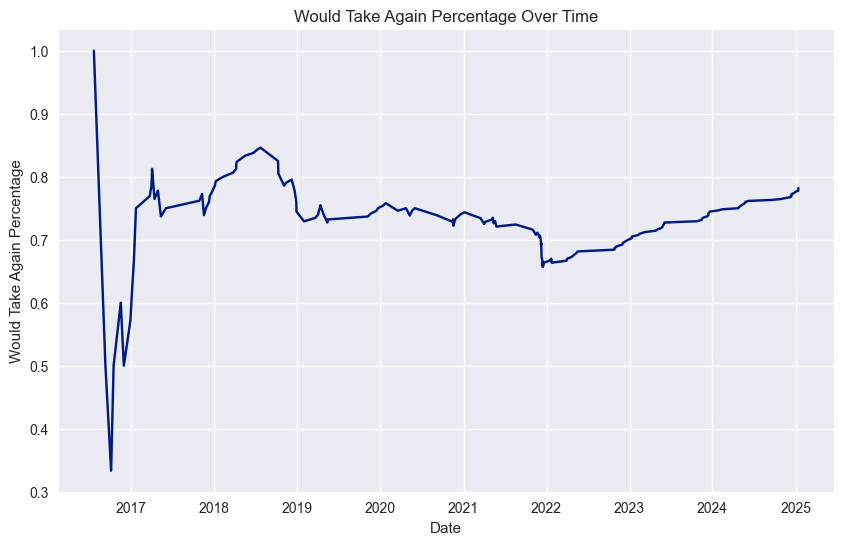

In [178]:
#Would take again percentage
def would_take_again_percentage(df):
    df = df.dropna(subset=['wouldTakeAgain'])
    return df['wouldTakeAgain'].mean()

print(would_take_again_percentage(df))

def would_take_again_percentage_over_time(df):
    df = df.dropna(subset=['wouldTakeAgain'])
    df = df.sort_values('datetime')
    df['would_take_again_percentage'] = df['wouldTakeAgain'].expanding().mean()
    return df[['datetime', 'would_take_again_percentage']]

would_take_again = would_take_again_percentage_over_time(df)

plt.figure(figsize=(10, 6))
plt.plot(would_take_again['datetime'], would_take_again['would_take_again_percentage'])
plt.xlabel('Date')
plt.ylabel('Would Take Again Percentage')
plt.title('Would Take Again Percentage Over Time')
plt.show()



In [179]:
print(df['attendanceMandatory'].value_counts())

attendanceMandatory
mandatory        200
non mandatory     36
                  32
N                  1
Y                  1
Name: count, dtype: int64


0.8445378151260504


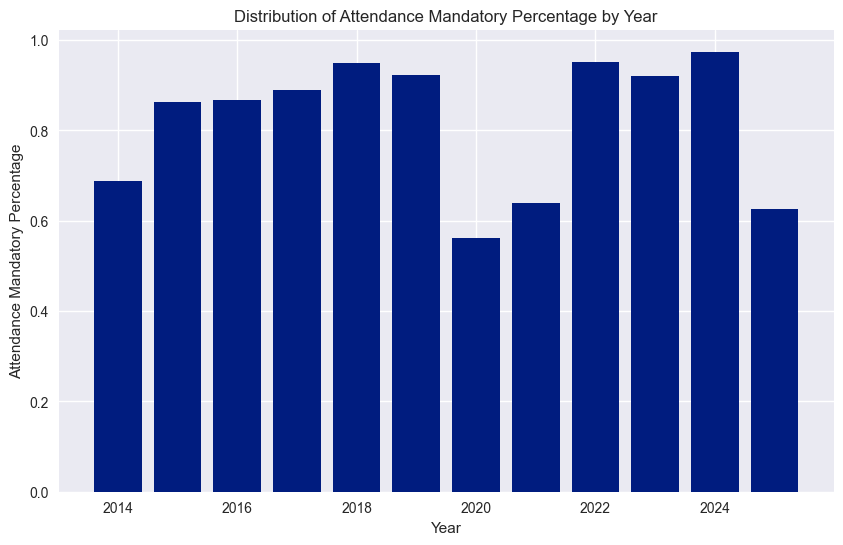

In [180]:
#Attendance mandatory percentage
def attendance_mandatory_percentage(df):
    df = df.dropna(subset=['attendanceMandatory'])
    df['attendanceMandatory'] = df['attendanceMandatory'].map({'mandatory': 1, 'non mandatory': 0, 'Y': 1, 'N': 0})
    df = df[df['attendanceMandatory'].isin([0,1])]
    return df['attendanceMandatory'].mean()

print(attendance_mandatory_percentage(df))

def mandatory_attendance_by_year(df):
    df = df.dropna(subset=['attendanceMandatory'])
    df['attendanceMandatory'] = df['attendanceMandatory'].map({'mandatory': 1, 'non mandatory': 0, 'Y': 1, 'N': 0})
    df = df[df['attendanceMandatory'].isin([0,1])]
    df = df.sort_values('datetime')
    df['year'] = df['datetime'].dt.year
    yearly_means = df.groupby('year')['attendanceMandatory'].mean().reset_index()
    yearly_means['datetime'] = pd.to_datetime(yearly_means['year'].astype(str) + '-01-01')
    return yearly_means[['datetime', 'attendanceMandatory']].rename(columns={'attendanceMandatory': 'attendance_mandatory_percentage'})

attendance_mandatory = mandatory_attendance_by_year(df)

plt.figure(figsize=(10, 6))
plt.bar(attendance_mandatory['datetime'].dt.year, attendance_mandatory['attendance_mandatory_percentage'])
plt.xlabel('Year')
plt.ylabel('Attendance Mandatory Percentage')
plt.title('Distribution of Attendance Mandatory Percentage by Year')
plt.show()



ratingTags
                                                                       100
Tough grader--Lecture heavy--Test heavy                                  4
Skip class? You won't pass.--Hilarious--Amazing lectures                 3
Skip class? You won't pass.--Lecture heavy                               3
Respected--Hilarious--Amazing lectures                                   3
                                                                      ... 
Clear grading criteria--Hilarious--Accessible outside class              1
Amazing lectures --Lots of homework                                      1
Lots of homework--Caring--Lecture heavy                                  1
Gives good feedback--Graded by few things--Accessible outside class      1
LOTS OF HOMEWORK--TEST HEAVY--LECTURE HEAVY                              1
Name: count, Length: 145, dtype: int64
tough_grader 45
participation_matters 35
test_heavy 30
Amazing_lectures  21
clear_grading_criteria 22
hilarious 33
lecture_he

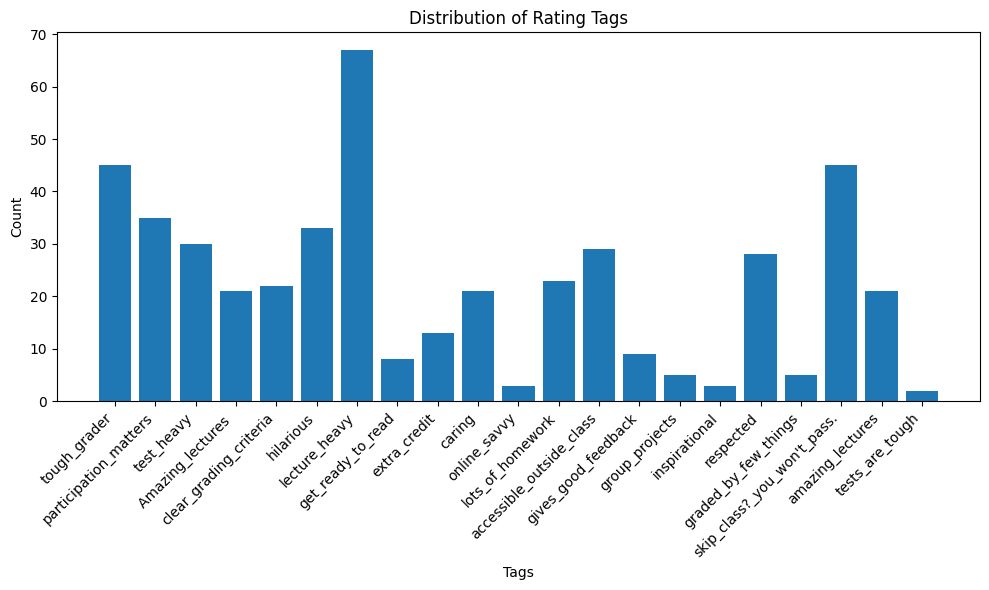

In [11]:
print(df['ratingTags'].value_counts())
Overall_tags = {}
for tag in df['ratingTags']:
    for t in tag.split('--'):
        if (t == ''):
            continue
        t = str(t[:-1].replace(' ', '_') + t[-1] if t.endswith(' ') else t.replace(' ', '_').lower())
        if (t not in Overall_tags):
            Overall_tags[str(t)] = 1
        else:
            Overall_tags[str(t)] += 1

for tag in Overall_tags:
    print(tag, Overall_tags[tag])

plt.figure(figsize=(10, 6))
plt.bar(Overall_tags.keys(), Overall_tags.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.title('Distribution of Rating Tags')
plt.tight_layout()
plt.show()


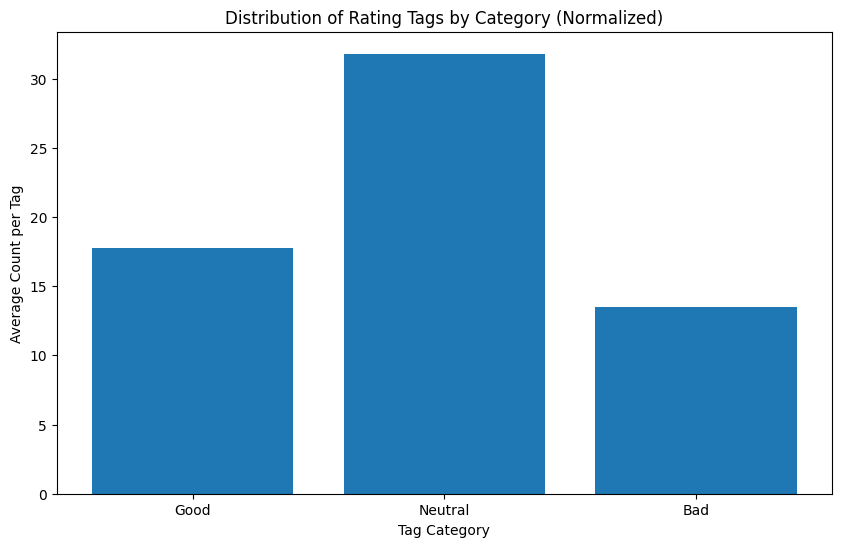

In [12]:
# Create dictionaries to classify tag
good_tags = {
    'amazing_lectures', 'caring', 'extra_credit',
    'gives_good_feedback', 'inspirational', 'respected',
    'accessible_outside_class', 'online_savvy', 'hilarious'
}

bad_tags = {
    'graded_by_few_things', 'tough_grader', 'get_ready_to_read',
    'lots_of_homework', 'so_many_papers', 'beware_of_pop_quizzes'
}

neutral_tags = {
    'lecture_heavy', 'test_heavy', 'participation_matters', 'group_projects', 'clear_grading_criteria'
}

# Count occurrences in each category and normalize by number of tags
good_count = sum(Overall_tags.get(tag, 0) for tag in good_tags) / len(good_tags)
bad_count = sum(Overall_tags.get(tag, 0) for tag in bad_tags) / len(bad_tags)
neutral_count = sum(Overall_tags.get(tag, 0) for tag in neutral_tags) / len(neutral_tags)

# Create bar plot of normalized tag categories
plt.figure(figsize=(10, 6))
plt.bar(['Good', 'Neutral', 'Bad'], [good_count, neutral_count, bad_count])
plt.xlabel('Tag Category')
plt.ylabel('Average Count per Tag')
plt.title('Distribution of Rating Tags by Category (Normalized)')
plt.show()



In [13]:
print(df['isForOnlineClass'].value_counts())

def is_online_percentage(df):
    df = df.dropna(subset=['isForOnlineClass'])
    df['isForOnlineClass'] = df['isForOnlineClass'].map({True: 1, False: 0})
    return df['isForOnlineClass'].mean()

print(is_online_percentage(df))

print(df['isForCredit'].value_counts())

def is_for_credit_percentage(df):
    df = df.dropna(subset=['isForCredit'])
    df['isForCredit'] = df['isForCredit'].map({True: 1, False: 0})
    return df['isForCredit'].mean()

print(is_for_credit_percentage(df))

def comment_length(df):
    df['comment_length'] = df['comment'].apply(len)
    return df['comment_length'].mean()

print(comment_length(df))


isForOnlineClass
False    258
True      12
Name: count, dtype: int64
0.044444444444444446
isForCredit
True     262
False      8
Name: count, dtype: int64
0.9703703703703703
292.6148148148148


C:\Users\austi\AppData\Local\Temp\ipykernel_14752\739836311.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=min_date, end=max_date, freq='M')


    month_year  count
0      2014-09      3
1      2014-10      8
2      2014-11     14
3      2014-12     10
4      2015-01      3
..         ...    ...
120    2024-09      1
121    2024-10      3
122    2024-11      5
123    2024-12     18
124    2025-01      7

[125 rows x 2 columns]


C:\Users\austi\AppData\Local\Temp\ipykernel_14752\739836311.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=min_date, end=max_date, freq='M')


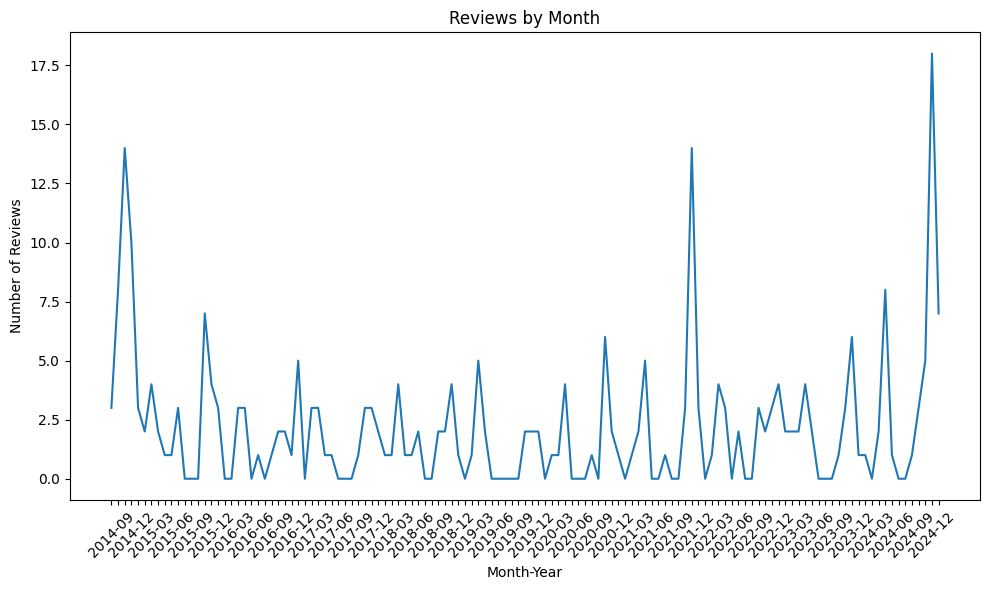

In [28]:
def reviews_by_month_year(df):
    # Get min and max dates
    min_date = df['datetime'].min()
    max_date = df['datetime'].max()
    
    # Create date range for all months between min and max
    date_range = pd.date_range(start=min_date, end=max_date, freq='M')
    
    # Initialize DataFrame with all months and zero counts
    result = pd.DataFrame({'month_year': date_range.to_period('M'), 'count': 0})
    
    # Convert df datetime to period for comparison
    df['month_year'] = df['datetime'].dt.to_period('M')
    
    # Iterate through df and increment counts where month_year matches
    for index, row in df.iterrows():
        match_idx = result[result['month_year'] == row['month_year']].index
        if len(match_idx) > 0:
            result.loc[match_idx[0], 'count'] += 1
            
    return result
print(reviews_by_month_year(df))

# Plot reviews by month
monthly_reviews = reviews_by_month_year(df)

plt.figure(figsize=(10, 6))
plt.plot(range(len(monthly_reviews)), monthly_reviews['count'])

# Create labels for every third month
all_months = monthly_reviews['month_year'].astype(str)
xtick_positions = range(len(all_months))
xtick_labels = [label if i % 3 == 0 else '' for i, label in enumerate(all_months)]

plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.xlabel('Month-Year')
plt.ylabel('Number of Reviews')
plt.title('Reviews by Month')
plt.tight_layout()
plt.show()



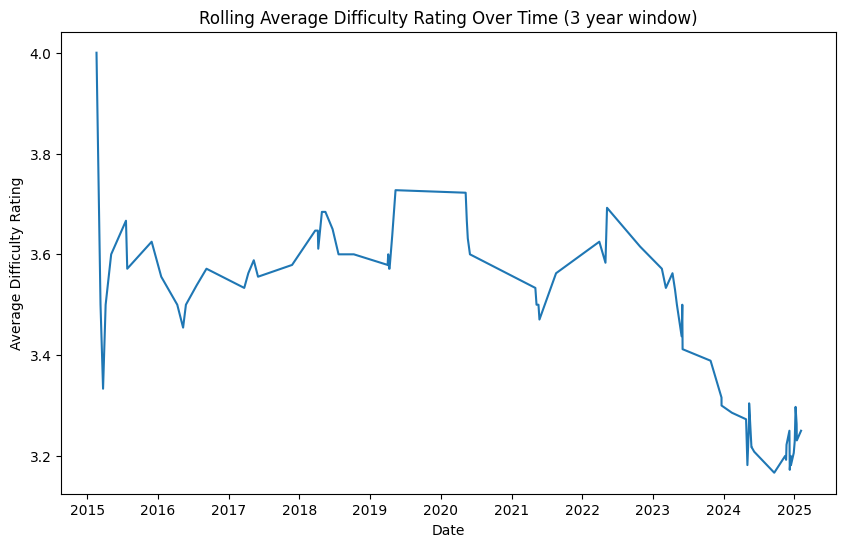

In [33]:
def filter_by_class(class_name):
    return df[df['class'] == class_name]

Bio152 = filter_by_class(class_name='BIO152')

rolling_difficulty = rolling_avg_difficulty_rating(Bio152)

plt.figure(figsize=(10, 6))
plt.plot(rolling_difficulty['datetime'], rolling_difficulty['rolling_avg_difficulty'])
plt.xlabel('Date')
plt.ylabel('Average Difficulty Rating')
plt.title('Rolling Average Difficulty Rating Over Time (3 year window)')
plt.show()


### Overall
- **Overall average quality rating**  
- **Overall average difficulty rating**  
- **Overall would take again percentage**  
- **Overall attendance mandatory percentage**  
- **Overall rating tags distribution**  
- **Ratings over time**  
- **Help the user better understand the data they’re viewing**  
- **Look at Preprocess & EDA for more ideas**

In [93]:
# Load all the reviews into a single df
import os
import pandas as pd

# Initialize empty list to store dataframes
dfs = []

# Walk through the RMPT100Reviews/combined directory
for root, dirs, files in os.walk('../RMPT100Reviews/universities'):
    for file in files:
        if file == 'reviews.csv':
            # Construct full file path
            file_path = os.path.join(root, file)
            # Read CSV and append to list
            df = pd.read_csv(file_path)
            dfs.append(df)

# Concatenate all dataframes
merged_df = pd.concat(dfs, ignore_index=True)

# Format numbers to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(merged_df.describe())


,index,clarity_rating,difficulty_rating,helpful_rating,quality_rating,textbook_use,thumbs_down_total,thumbs_up_total,would_take_again,pid
count,3396084.000,3396084.000,3396084.000,3396084.000,3396084.000,2962539.000,3396084.000,3396084.000,1514149.000,3396084.000
mean,27498.122,3.644,3.052,3.668,3.734,2.402,0.335,0.593,0.778,1298904.319
std,21383.378,1.500,1.222,1.517,1.480,2.193,2.476,8.208,0.416,913176.954
min,0.000,1.000,1.000,-1.000,1.000,-1.000,-99.000,-99.000,0.000,47.000
25%,10019.000,2.000,2.000,2.000,3.000,0.000,0.000,0.000,1.000,420036.000
50%,22674.000,4.000,3.000,4.000,4.000,3.000,0.000,0.000,1.000,1206166.000
75%,40959.000,5.000,4.000,5.000,5.000,5.000,0.000,0.000,1.000,2108671.000
max,107192.000,5.000,5.000,5.000,5.000,5.000,964.000,13600.000,1.000,3073231.000


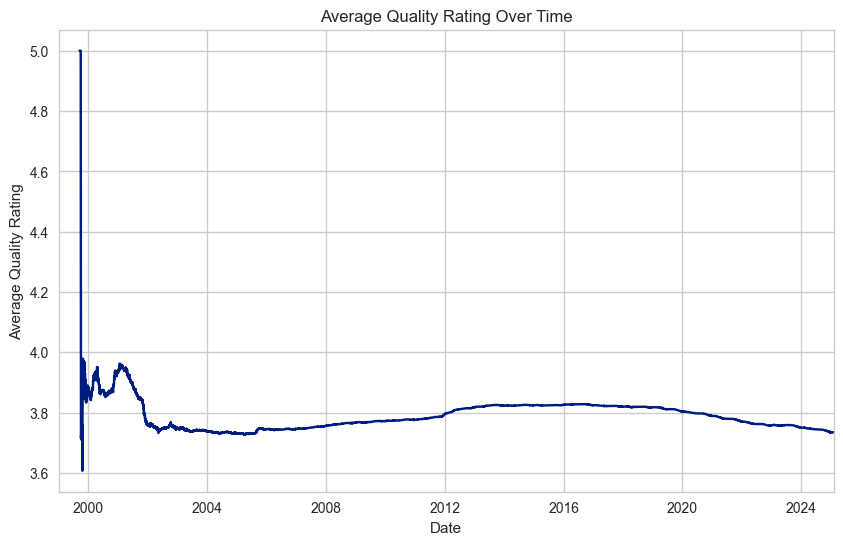

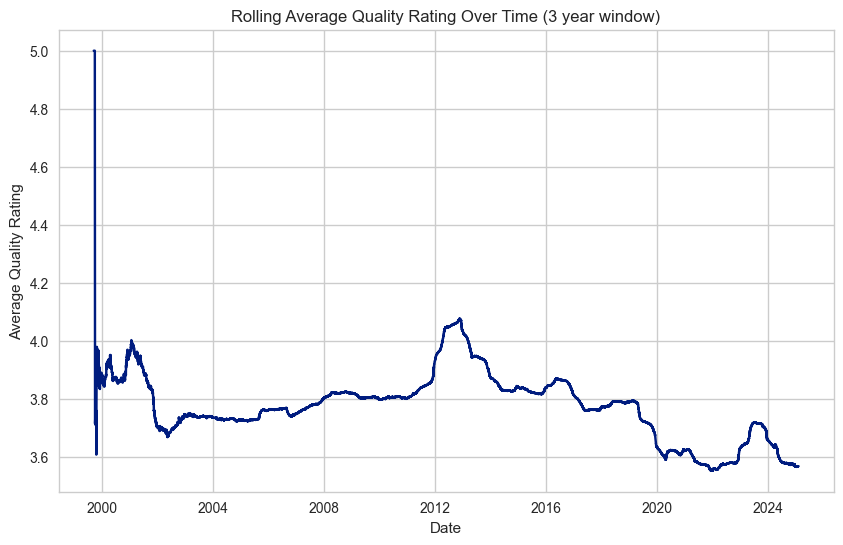

In [94]:
merged_df['datetime'] = pd.to_datetime(merged_df['date'])

def avg_quality_rating(df):
    df = df.sort_values('datetime')
    df['avg_quality'] = df['quality_rating'].expanding().mean()
    return df[['datetime', 'avg_quality']]

avg_quality = avg_quality_rating(merged_df)

# Set date range from 1999 to 2025
plt.figure(figsize=(10, 6))
plt.plot(avg_quality['datetime'], avg_quality['avg_quality'])
plt.xlim(pd.Timestamp('1999-01-01'), pd.Timestamp('2025-02-01'))
plt.xlabel('Date')
plt.ylabel('Average Quality Rating')
plt.title('Average Quality Rating Over Time')
plt.show()
def rolling_avg_quality_rating(df, window_years=1):
    # Convert datetime to datetime type if not already
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    
    # Calculate number of days in window
    window_days = f"{365 * window_years}D"
    
    # Set datetime as index and calculate rolling average
    df = df.set_index('datetime')
    df['rolling_avg_quality'] = df['quality_rating'].rolling(window=window_days, min_periods=1).mean()
    df = df.reset_index()
    
    return df[['datetime', 'rolling_avg_quality']]

rolling_quality = rolling_avg_quality_rating(merged_df)

plt.figure(figsize=(10, 6))
plt.plot(rolling_quality['datetime'], rolling_quality['rolling_avg_quality'])
plt.xlabel('Date')
plt.ylabel('Average Quality Rating')
plt.title('Rolling Average Quality Rating Over Time (3 year window)')
plt.show()


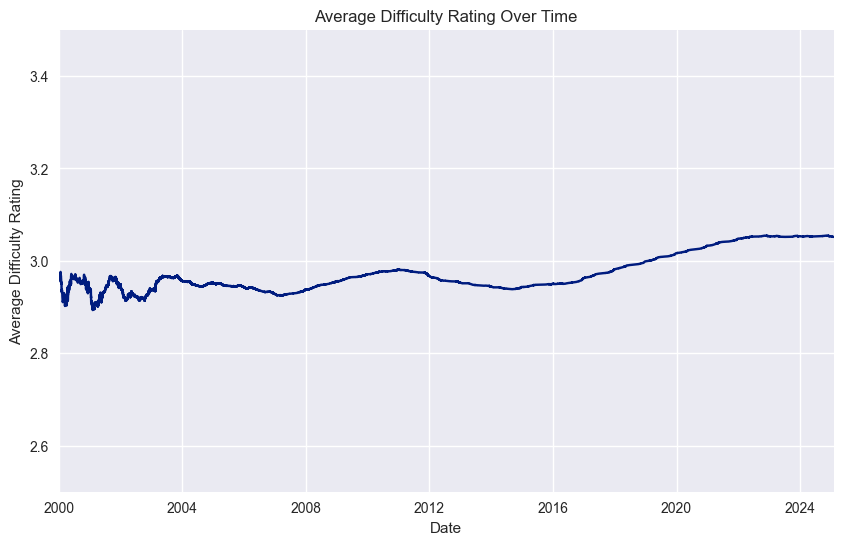

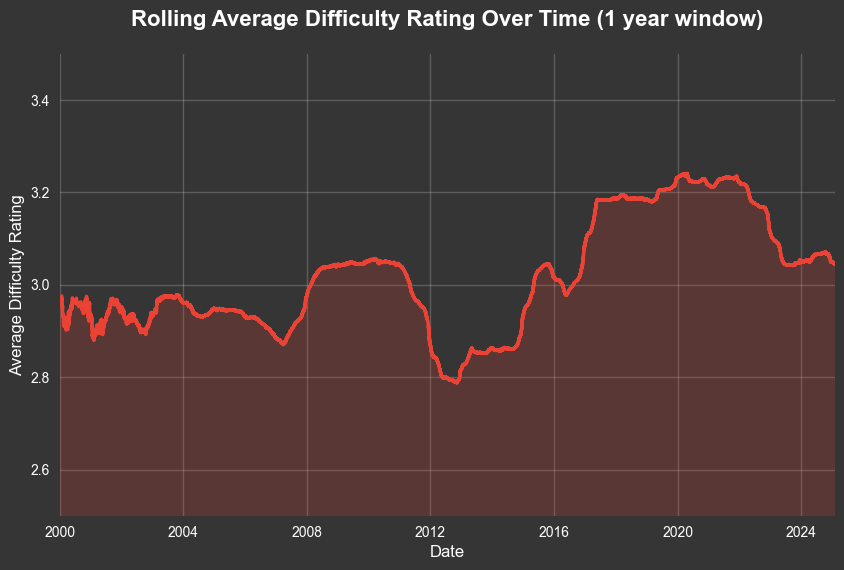

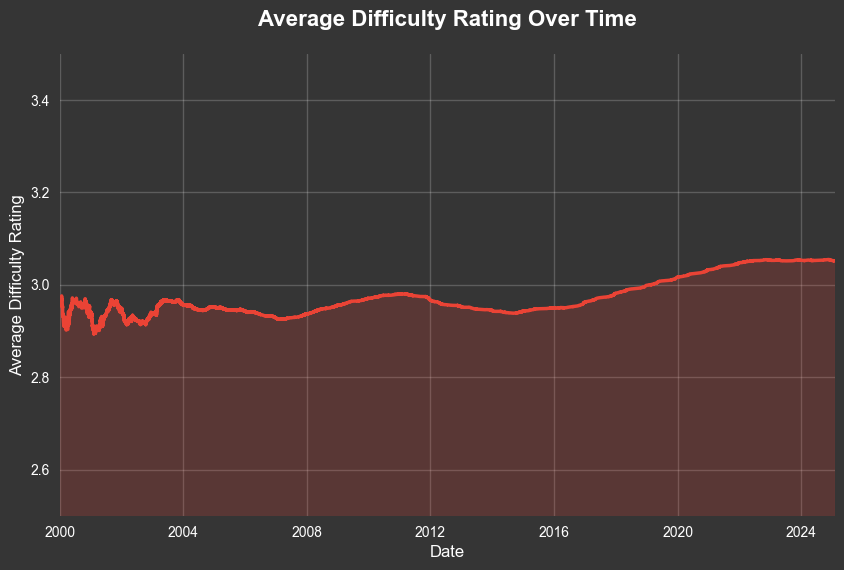

In [170]:
# Difficulty Rating over time
def avg_difficulty_rating(df):
    df = df.sort_values('datetime')
    df['avg_difficulty'] = df['difficulty_rating'].expanding().mean()
    return df[['datetime', 'avg_difficulty']]

avg_difficulty = avg_difficulty_rating(merged_df)

plt.figure(figsize=(10, 6))
plt.plot(avg_difficulty['datetime'], avg_difficulty['avg_difficulty'])
plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01'))
plt.ylim(2.5, 3.5)
plt.xlabel('Date')
plt.ylabel('Average Difficulty Rating')
plt.title('Average Difficulty Rating Over Time')
plt.show()
    
def rolling_avg_difficulty_rating(df, window_years=1):
    window_days = f"{365 * window_years}D"
    df = df.sort_values('datetime')
    df = df.set_index('datetime')
    df['rolling_avg_difficulty'] = df['difficulty_rating'].rolling(window=window_days, min_periods=1).mean()
    df = df.reset_index()
    return df[['datetime', 'rolling_avg_difficulty']]

rolling_difficulty = rolling_avg_difficulty_rating(merged_df)

def create_rolling_difficulty_plot(rolling_difficulty):
    # Create figure and axis with minimal styling
    plt.style.use('seaborn-v0_8-dark-palette')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set background color
    fig.patch.set_facecolor('#353535')
    ax.set_facecolor('#353535')
    
    # Plot rolling average data with shaded area
    ax.plot(rolling_difficulty['datetime'], 
            rolling_difficulty['rolling_avg_difficulty'],
            color='#ea4335',
            linewidth=2.5)
    ax.fill_between(rolling_difficulty['datetime'],
                    rolling_difficulty['rolling_avg_difficulty'],
                    color='#ea4335',
                    alpha=0.2)
    
    # Configure rolling average plot
    ax.set_title('Rolling Average Difficulty Rating Over Time (1 year window)',
                 fontsize=16,
                 pad=20,
                 color='white',
                 weight='bold')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel('Average Difficulty Rating', fontsize=12, color='white')
    
    # Set axis ranges and styling
    ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01'))
    ax.set_ylim(2.5, 3.5)
    ax.grid(True, linestyle='-', alpha=0.2, color='white')
    ax.tick_params(colors='white')
    
    plt.show()

def create_avg_difficulty_plot(avg_difficulty):
    # Create figure and axis with minimal styling 
    plt.style.use('seaborn-v0_8-dark-palette')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set background color
    fig.patch.set_facecolor('#353535')
    ax.set_facecolor('#353535')
    
    # Plot average data with shaded area
    ax.plot(avg_difficulty['datetime'],
            avg_difficulty['avg_difficulty'], 
            color='#ea4335',
            linewidth=2.5)
    ax.fill_between(avg_difficulty['datetime'],
                    avg_difficulty['avg_difficulty'],
                    color='#ea4335',
                    alpha=0.2)
    
    # Configure average plot
    ax.set_title('Average Difficulty Rating Over Time',
                 fontsize=16,
                 pad=20,
                 color='white',
                 weight='bold')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel('Average Difficulty Rating', fontsize=12, color='white')
    
    # Set axis ranges and styling
    ax.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01'))
    ax.set_ylim(2.5, 3.5)
    ax.grid(True, linestyle='-', alpha=0.2, color='white')
    ax.tick_params(colors='white')
    
    plt.show()

# Create and display the plots
create_rolling_difficulty_plot(rolling_difficulty)
create_avg_difficulty_plot(avg_difficulty)


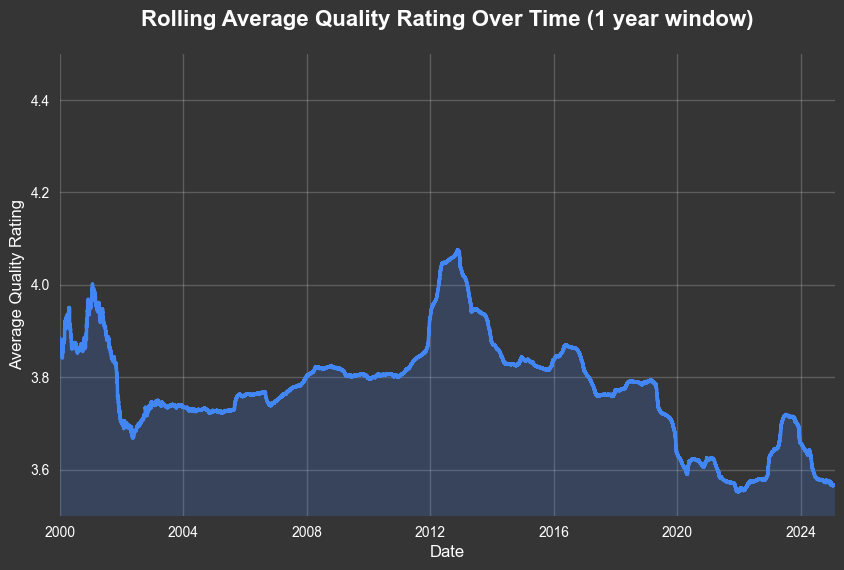

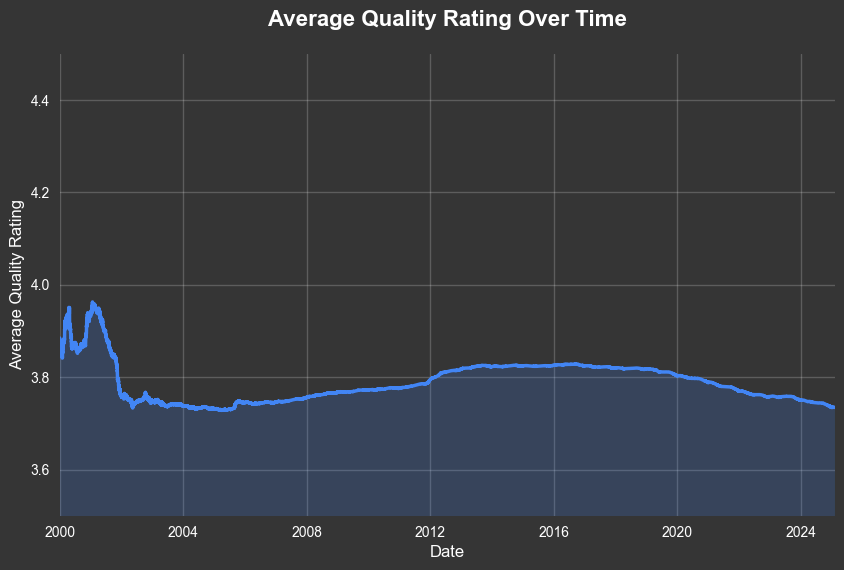

In [171]:
# Can combine avg and rolling window into reuseable function

def create_dual_plot_template(data1, data2, x_col, y_col1, y_col2, 
                            title1, title2, y_label, 
                            x_lim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01')),
                            y_lim=(2.5, 3.5), color='#2196f3'):
    """
    Creates a dual plot with consistent styling for time series data
    
    Parameters:
    -----------
    data1, data2 : pandas DataFrames containing the data to plot
    x_col : str, column name for x-axis data (typically datetime)
    y_col1, y_col2 : str, column names for y-axis data for each plot
    title1, title2 : str, titles for top and bottom plots
    y_label : str, label for y-axis (shared between plots)
    x_lim : tuple of timestamps, optional x-axis limits
    y_lim : tuple of floats, optional y-axis limits
    """
    # Create figure and axis with minimal styling
    plt.style.use('seaborn-v0_8-dark-palette')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Set background color
    fig.patch.set_facecolor('#353535')
    ax1.set_facecolor('#353535')
    ax2.set_facecolor('#353535')
    
    # Plot data with shaded area - top plot
    ax1.plot(data1[x_col], data1[y_col1],
             color=color,
             linewidth=2.5)
    ax1.fill_between(data1[x_col], data1[y_col1],
                     color=color,
                     alpha=0.2)
    
    # Configure top plot
    ax1.set_title(title1,
                  fontsize=16,
                  pad=20,
                  color='white',
                  weight='bold')
    ax1.set_xlabel('Date', fontsize=12, color='white')
    ax1.set_ylabel(y_label, fontsize=12, color='white')
    
    # Plot data with shaded area - bottom plot
    ax2.plot(data2[x_col], data2[y_col2],
             color=color,
             linewidth=2.5)
    ax2.fill_between(data2[x_col], data2[y_col2],
                     color=color,
                     alpha=0.2)
    
    # Configure bottom plot
    ax2.set_title(title2,
                  fontsize=16,
                  pad=20,
                  color='white',
                  weight='bold')
    ax2.set_xlabel('Date', fontsize=12, color='white')
    ax2.set_ylabel(y_label, fontsize=12, color='white')
    
    # Set axis ranges and styling for both plots
    for ax in [ax1, ax2]:
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.grid(True, linestyle='-', alpha=0.2, color='white')
        ax.tick_params(colors='white')
    
    # Add padding between plots
    plt.subplots_adjust(hspace=0.3)
    
    return fig

# Get the average and rolling quality data
avg_quality = avg_quality_rating(merged_df)
rolling_quality = rolling_avg_quality_rating(merged_df)

# Create and display the plot using the template
# Create rolling average plot
# Create rolling average plot
plt.style.use('seaborn-v0_8-dark-palette')
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Set background color
fig1.patch.set_facecolor('#353535')
ax1.set_facecolor('#353535')

# Plot rolling average data with shaded area
ax1.plot(rolling_quality['datetime'], 
        rolling_quality['rolling_avg_quality'],
        color='#4285f4',
        linewidth=2.5)
ax1.fill_between(rolling_quality['datetime'],
                rolling_quality['rolling_avg_quality'],
                color='#4285f4',
                alpha=0.2)

# Configure rolling average plot
ax1.set_title('Rolling Average Quality Rating Over Time (1 year window)',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax1.set_xlabel('Date', fontsize=12, color='white')
ax1.set_ylabel('Average Quality Rating', fontsize=12, color='white')

# Set axis ranges and styling
ax1.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01'))
ax1.set_ylim(3.5, 4.5)
ax1.grid(True, linestyle='-', alpha=0.2, color='white')
ax1.tick_params(colors='white')

plt.show()

# Create average plot
plt.style.use('seaborn-v0_8-dark-palette')
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Set background color
fig2.patch.set_facecolor('#353535')
ax2.set_facecolor('#353535')

# Plot average data with shaded area
ax2.plot(avg_quality['datetime'],
        avg_quality['avg_quality'], 
        color='#4285f4',
        linewidth=2.5)
ax2.fill_between(avg_quality['datetime'],
                avg_quality['avg_quality'],
                color='#4285f4',
                alpha=0.2)

# Configure average plot
ax2.set_title('Average Quality Rating Over Time',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax2.set_xlabel('Date', fontsize=12, color='white')
ax2.set_ylabel('Average Quality Rating', fontsize=12, color='white')

# Set axis ranges and styling
ax2.set_xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01'))
ax2.set_ylim(3.5, 4.5)
ax2.grid(True, linestyle='-', alpha=0.2, color='white')
ax2.tick_params(colors='white')
plt.show()


In [97]:
def create_plot_template(data, x_col, y_col, title, y_label,
                        x_lim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01')),
                        y_lim=(2.5, 3.5), color='#bc1f1f'):
    """
    Creates a single plot with consistent styling for time series data
    
    Parameters:
    -----------
    data : pandas DataFrame containing the data to plot
    x_col : str, column name for x-axis data (typically datetime)
    y_col : str, column name for y-axis data
    title : str, title for the plot
    y_label : str, label for y-axis
    x_lim : tuple of timestamps, optional x-axis limits
    y_lim : tuple of floats, optional y-axis limits
    """
    # Create figure and axis with minimal styling
    plt.style.use('seaborn-v0_8-dark-palette')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set background color
    fig.patch.set_facecolor('#353535')
    ax.set_facecolor('#353535')
    
    # Plot data with shaded area
    ax.plot(data[x_col], data[y_col],
            color=color,
            linewidth=2.5)
    ax.fill_between(data[x_col], data[y_col],
                    color=color,
                    alpha=0.2)
    
    # Configure plot
    ax.set_title(title,
                 fontsize=16,
                 pad=20,
                 color='white',
                 weight='bold')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel(y_label, fontsize=12, color='white')
    
    # Set axis ranges and styling
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid(True, linestyle='-', alpha=0.2, color='white')
    ax.tick_params(colors='white')
    
    return fig

0.7729468599033816
Overall would take again percentage: 77.8%


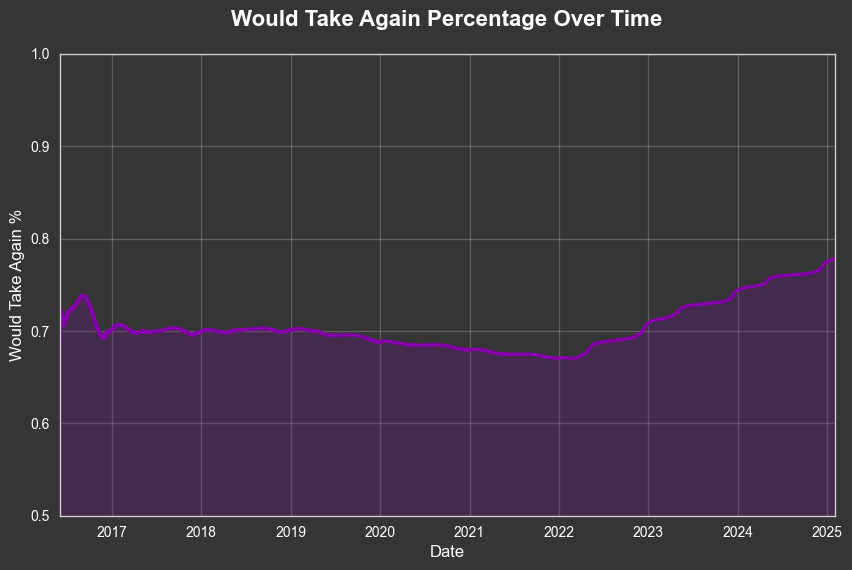

In [98]:

#Would take again percentage
def would_take_again_percentage(df):
    df = df.dropna(subset=['would_take_again'])
    return df['would_take_again'].mean()

print(would_take_again_percentage(df))

def would_take_again_percentage_over_time(df):
    df = df.dropna(subset=['would_take_again'])
    df = df.sort_values('datetime')
    df['would_take_again_percentage'] = df['would_take_again'].expanding().mean()
    return df[['datetime', 'would_take_again_percentage']]

# Calculate overall would take again percentage
print(f"Overall would take again percentage: {would_take_again_percentage(merged_df):.1%}")

# Get would take again percentage over time
would_take_again = would_take_again_percentage_over_time(merged_df)

# Create plot using template
create_plot_template(
    data=would_take_again,
    x_col='datetime',
    y_col='would_take_again_percentage',
    title='Would Take Again Percentage Over Time',
    y_label='Would Take Again %',
    x_lim=(pd.Timestamp('2016-06-01'), pd.Timestamp('2025-02-01')),
    y_lim=(0.5, 1.0),
    color='#8501aa'
)
plt.show()


In [99]:
# Calculate overall difficulty and quality rating stats
print(f"Overall average difficulty rating: {merged_df['difficulty_rating'].mean():.10f}")
print(f"Overall average quality rating: {merged_df['quality_rating'].mean():.10f}")

print("\nDifficulty rating distribution:")
print(merged_df['difficulty_rating'].value_counts(normalize=True).sort_index().to_frame())

print("\nQuality rating distribution:") 
print(merged_df['quality_rating'].value_counts(normalize=True).sort_index().to_frame())


Overall average difficulty rating: 3.0516141532
Overall average quality rating: 3.7344438477

Difficulty rating distribution:
                   proportion
difficulty_rating            
1.000                   0.124
2.000                   0.210
3.000                   0.294
4.000                   0.233
5.000                   0.139

Quality rating distribution:
                proportion
quality_rating            
1.000                0.141
2.000                0.102
3.000                0.109
4.000                0.176
5.000                0.472


C:\Users\austi\AppData\Local\Temp\ipykernel_14752\4214526713.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.5875601431834913
    year  attendance_mandatory   datetime
0   1999                57.143 1999-01-01
1   2000                62.500 2000-01-01
2   2001                68.509 2001-01-01
3   2002                65.833 2002-01-01
4   2004                69.420 2004-01-01
5   2005                68.980 2005-01-01
6   2006                83.333 2006-01-01
7   2011                 0.000 2011-01-01
8   2013                59.811 2013-01-01
9   2014                58.409 2014-01-01
10  2015                60.759 2015-01-01
11  2016                62.912 2016-01-01
12  2017                63.475 2017-01-01
13  2018                63.411 2018-01-01
14  2019                62.966 2019-01-01
15  2020                59.872 2020-01-01
16  2021                55.095 2021-01-01
17  2022                52.912 2022-01-01
18  2023                55.152 2023-01-01
19  2024                57.498 2024-01-01
20  2025                59.766 2025-01-01


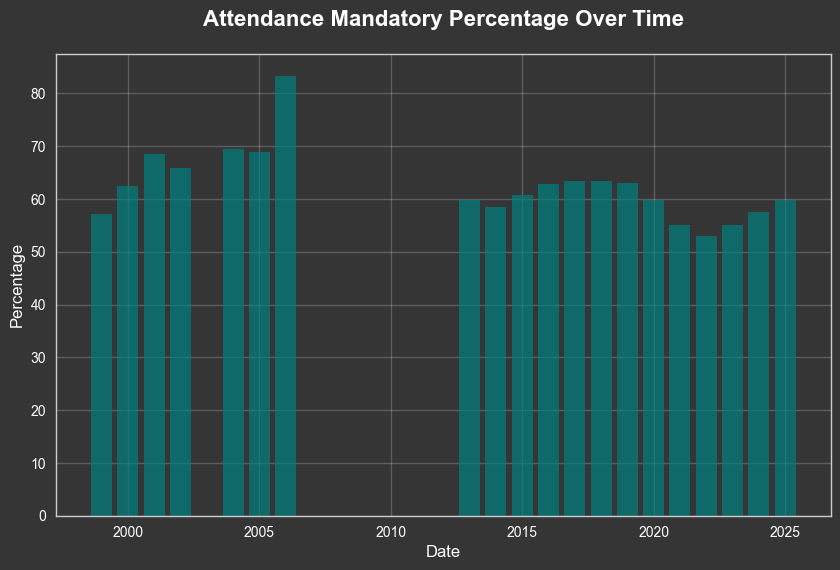

In [107]:
def create_histogram_template(data, col, title, x_label, bins=30, color='#bc1f1f'):
    """
    Creates a histogram plot with consistent styling, grouped by year
    
    Parameters:
    -----------
    data : pandas DataFrame containing the data to plot
    col : str, column name for the data to histogram
    title : str, title for the plot
    x_label : str, label for x-axis
    bins : int, number of bins for histogram
    color : str, color for the bars
    """
    # Create figure and axis with minimal styling
    plt.style.use('seaborn-v0_8-dark-palette')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set background color
    fig.patch.set_facecolor('#353535')
    ax.set_facecolor('#353535')
    
    # Plot bar chart using the data
    plt.bar(data['datetime'].dt.year,
           data[col],
           color=color,
           alpha=0.7,
           width=0.8)
    
    # Configure plot
    ax.set_title(title,
                 fontsize=16,
                 pad=20,
                 color='white',
                 weight='bold')
    ax.set_xlabel(x_label, fontsize=12, color='white')
    ax.set_ylabel('Percentage', fontsize=12, color='white')
    
    # Set axis styling
    ax.grid(True, linestyle='-', alpha=0.2, color='white')
    ax.tick_params(colors='white')
    
    return fig

# Attendance mandatory percentage
def attendance_mandatory_percentage(df):
    df = df.dropna(subset=['attendance_mandatory'])
    df['attendance_mandatory'] = df['attendance_mandatory'].map({'mandatory': 1, 'non mandatory': 0, 'Y': 1, 'N': 0})
    df = df[df['attendance_mandatory'].isin([0,1])]
    return df['attendance_mandatory'].mean()

print(attendance_mandatory_percentage(merged_df))

def mandatory_attendance_by_year(df):
    # Make a copy to avoid modifying original dataframe
    df = df.copy()
    
    # Clean attendance data
    df = df.dropna(subset=['attendance_mandatory'])
    df['attendance_mandatory'] = df['attendance_mandatory'].map({'mandatory': 1, 'non mandatory': 0, 'Y': 1, 'N': 0})
    df = df[df['attendance_mandatory'].isin([0,1])]
    
    # Group by year and calculate mean attendance percentage
    yearly_means = df.groupby(df['datetime'].dt.year).agg({
        'attendance_mandatory': lambda x: x.mean() * 100
    }).reset_index()
    yearly_means.columns = ['year', 'attendance_mandatory']
    
    # Convert year to datetime 
    yearly_means['datetime'] = pd.to_datetime(yearly_means['year'].astype(str) + '-01-01')

    print(yearly_means)
    
    return yearly_means[['datetime', 'attendance_mandatory']].rename(
        columns={'attendance_mandatory': 'attendance_mandatory_percentage'}
    )

attendance_mandatory = mandatory_attendance_by_year(merged_df)

create_histogram_template(
    data=attendance_mandatory,
    col='attendance_mandatory_percentage',
    title='Attendance Mandatory Percentage Over Time',
    x_label='Date',
    bins=26,
    color='#008080'
)
plt.show()

rating_tags
Tough grader                                                     19186
Lecture heavy                                                    11112
Get ready to read                                                 9646
Graded by few things                                              9559
Lots of homework                                                  9117
                                                                 ...  
Lecture heavy--Lots of homework--EXTRA CREDIT                        1
TEST HEAVY--Get ready to read                                        1
EXTRA CREDIT--Lots of homework--Get ready to read                    1
Hilarious--Skip class? You won't pass.--Participation matters        1
SO MANY PAPERS--Amazing lectures--Tests are tough                    1
Name: count, Length: 8366, dtype: int64
gives_good_feedback 250583
accessible_outside_class 250308
lecture_heavy 271503
respected 225100
inspirational 139882
caring 374633
amazing_lectures 140050
tests?_not_

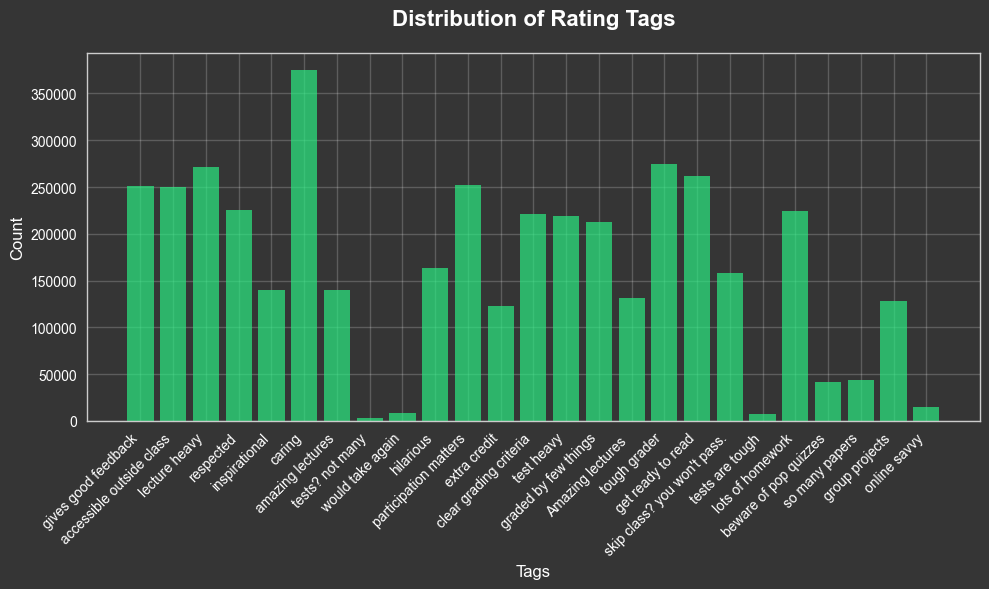

In [114]:
print(merged_df['rating_tags'].value_counts())
Overall_tags = {}
for tag in merged_df['rating_tags'].dropna():
    for t in str(tag).split('--'):
        if (t == ''):
            continue
        t = str(t[:-1].replace(' ', '_') + t[-1] if t.endswith(' ') else t.replace(' ', '_').lower())
        if (t not in Overall_tags):
            Overall_tags[str(t)] = 1
        else:
            Overall_tags[str(t)] += 1

popped_tags = []
for tag in Overall_tags:
    if Overall_tags[tag] > 1000:
        print(tag, Overall_tags[tag])
    else: 
        popped_tags.append(tag)

for tag in popped_tags:
    Overall_tags.pop(tag)

# Convert keys from snake_case to space-separated
Overall_tags = {key.replace('_', ' '): value for key, value in Overall_tags.items()}


# Create figure and axis with minimal styling
plt.style.use('seaborn-v0_8-dark-palette')
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Plot bar chart using the data
plt.bar(Overall_tags.keys(), 
        Overall_tags.values(),
        color='#2aeb81',
        alpha=0.7,
        width=0.8)

# Configure plot
ax.set_title('Distribution of Rating Tags',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax.set_xlabel('Tags', fontsize=12, color='white')
ax.set_ylabel('Count', fontsize=12, color='white')

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='white')
ax.tick_params(colors='white')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

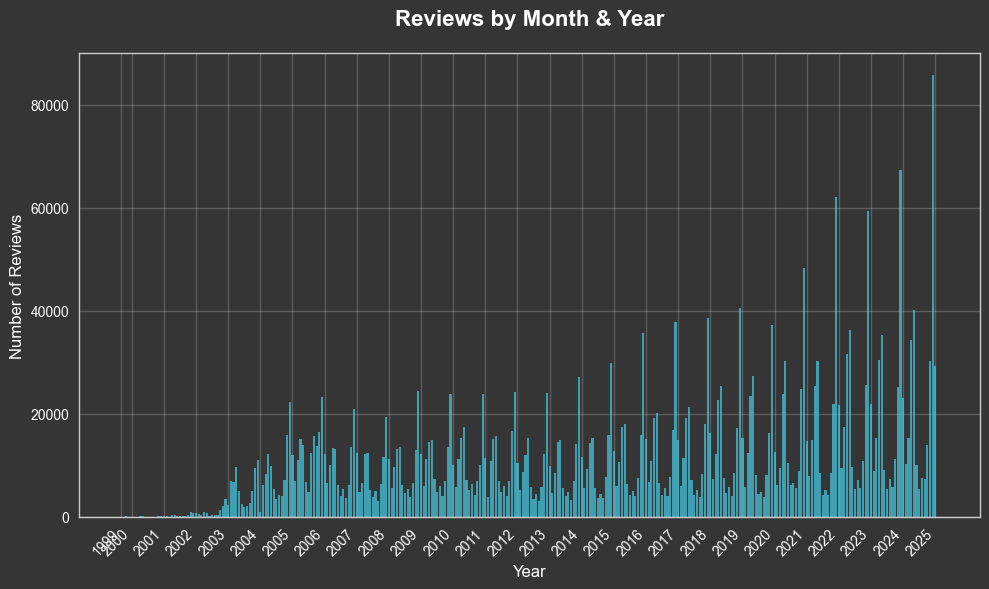

In [130]:
def reviews_by_month_year(df):
    # Convert datetime to period for grouping by month
    df_monthly = df['datetime'].dt.to_period('M')
    
    # Count reviews per month using value_counts
    monthly_counts = df_monthly.value_counts().sort_index()
    
    # Create date range for all months between min and max
    min_date = df['datetime'].min()
    max_date = df['datetime'].max()
    
    # Convert to period index to match monthly_counts index
    date_range = pd.period_range(start=min_date, end=max_date, freq='M')
    
    # Create DataFrame with all months and merge with counts
    result = pd.DataFrame(index=date_range)
    result['count'] = 0
    result.loc[monthly_counts.index, 'count'] = monthly_counts
    result.reset_index(inplace=True)
    result.rename(columns={'index': 'month_year'}, inplace=True)
    
    return result

# Plot reviews by month
monthly_reviews = reviews_by_month_year(merged_df)

# Create figure and axis with minimal styling
plt.style.use('seaborn-v0_8-dark-palette')
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Plot bar chart
plt.bar(range(len(monthly_reviews)), 
        monthly_reviews['count'],
        color='#47cde8',
        alpha=0.7,
        width=0.8)

# Create labels for years only
years = monthly_reviews['month_year'].dt.year.astype(str)
xtick_positions = range(len(monthly_reviews))
unique_years = years.unique()
year_positions = [i for i, year in enumerate(years) if year in unique_years and years.iloc[i-1] != year]
year_labels = [years[i] for i in year_positions]

# Configure plot
ax.set_title('Reviews by Month & Year',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax.set_xlabel('Year', fontsize=12, color='white')
ax.set_ylabel('Number of Reviews', fontsize=12, color='white')

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='white')
ax.tick_params(colors='white')
plt.xticks(year_positions, year_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

{'1999': 313, '2000': 895, '2001': 3815, '2002': 12032, '2003': 65713, '2004': 99778, '2005': 152180, '2006': 115305, '2007': 102821, '2008': 117393, '2009': 125419, '2010': 123822, '2011': 126478, '2012': 110559, '2013': 118709, '2014': 127001, '2015': 143124, '2016': 154774, '2017': 158566, '2018': 172390, '2019': 167281, '2020': 193095, '2021': 207787, '2022': 240350, '2023': 243436, '2024': 283787, '2025': 29261}


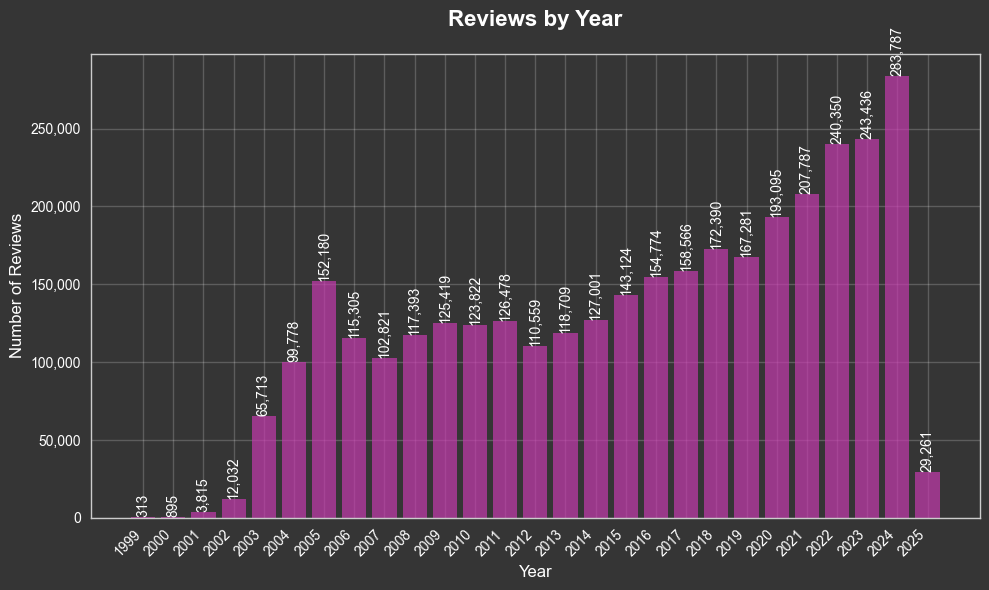

In [128]:
yearly_reviews = {}
for index, row in monthly_reviews.iterrows():
    year = str(row['month_year'].year)
    if year not in yearly_reviews:
        yearly_reviews[year] = row['count']
    else:
        yearly_reviews[year] += row['count']

print(yearly_reviews)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Convert dictionary to lists for plotting
years = list(yearly_reviews.keys())
counts = list(yearly_reviews.values())

# Plot bar chart
bars = plt.bar(years, counts,
               color='#c53aae',
               alpha=0.7,
               width=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='white',
            fontsize=10,
            rotation=90)

# Configure plot
ax.set_title('Reviews by Year',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax.set_xlabel('Year', fontsize=12, color='white')
ax.set_ylabel('Number of Reviews', fontsize=12, color='white')

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='white')
ax.tick_params(colors='white')
plt.xticks(rotation=45, ha='right')

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()



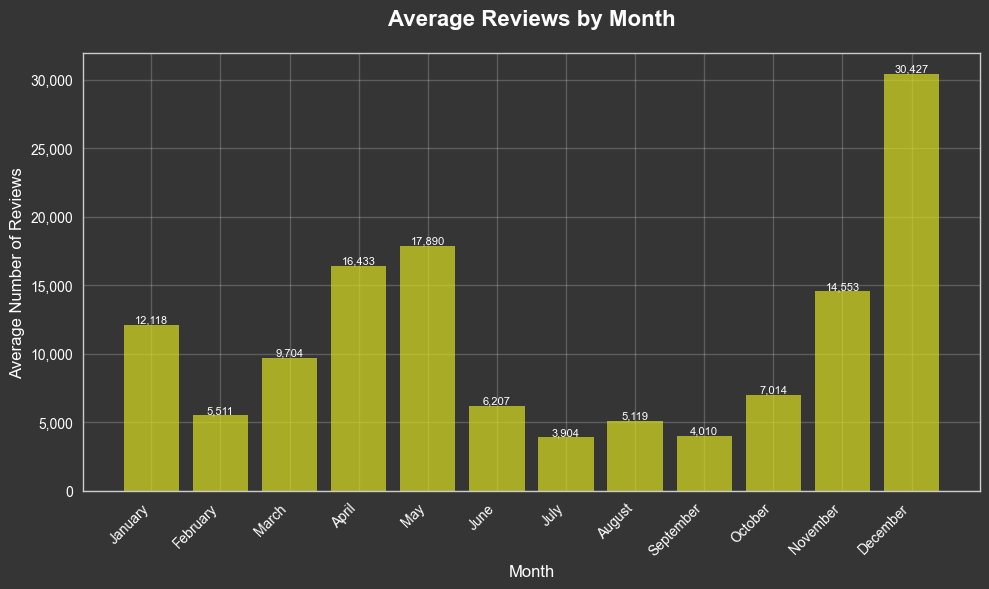

In [127]:
# Group reviews by month number and calculate average count
monthly_data = {}
for index, row in monthly_reviews.iterrows():
    month = row['month_year'].strftime('%B')  # Get month name
    if month not in monthly_data:
        monthly_data[month] = []
    monthly_data[month].append(row['count'])

# Calculate average count for each month
avg_monthly_data = {month: sum(counts)/len(counts) for month, counts in monthly_data.items()}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Convert dictionary to lists for plotting
months = list(avg_monthly_data.keys())
counts = list(avg_monthly_data.values())

# Reorder months chronologically
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
counts = [avg_monthly_data[month] for month in month_order]
# Plot bar chart
bars = plt.bar(month_order, counts,
               color='#dade21',
               alpha=0.7,
               width=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='white',
            fontsize=8,
            rotation=0)  # Changed rotation to 0 for horizontal text

# Configure plot
ax.set_title('Average Reviews by Month',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax.set_xlabel('Month', fontsize=12, color='white')
ax.set_ylabel('Average Number of Reviews', fontsize=12, color='white')

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='white')
ax.tick_params(colors='white')
plt.xticks(rotation=45, ha='right')

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()


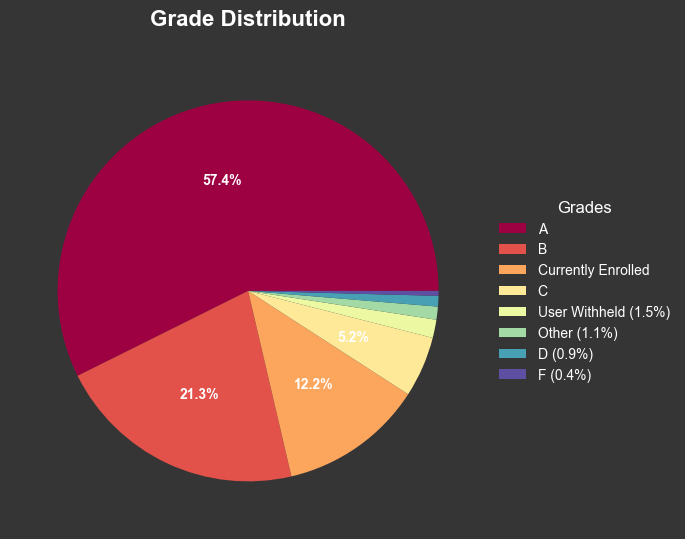

In [150]:
import numpy as np
# Create a mapping of grades to custom labels
grade_mapping = {
    'Not_Sure_Yet': 'Currently Enrolled',
    'Not sure yet': 'Currently Enrolled',
    'Incomplete': 'Other',
    'Audit/No Grade': 'Other',
    'Drop/Withdraw': 'Other',
    'Rather_Not_Say': 'User Withheld',
    'Rather not say': 'User Withheld',
    'Pass': 'Other',
    'Fail': 'Other',
    'wombo combo': 'Other',
    'A': 'A',
    'A-': 'A',
    'B+': 'B',
    'B': 'B',
    'B-': 'B',
    'C+': 'C',
    'C': 'C',
    'C-': 'C',
    'D+': 'D',
    'D': 'D',
    'D-': 'D',
    'F': 'F',
    'F-': 'F',
    'F+': 'F',
}

# Apply mapping and plot
grade_counts = merged_df['grade'].map(grade_mapping).value_counts()

# Create figure and axis with dark theme
fig, ax = plt.subplots(figsize=(8, 5.5))
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Calculate percentages
pcts = grade_counts / grade_counts.sum() * 100

# Create custom autopct function
def make_autopct(pcts):
    def autopct(pct):
        return f'{pct:.1f}%' if pct >= 2 else ''
    return autopct

# Create pie chart
wedges, texts, autotexts = ax.pie(grade_counts,
                                 labels=grade_counts.index,
                                 autopct=make_autopct(pcts),
                                 textprops={'color': '#353535'},
                                 colors=plt.cm.Spectral(np.linspace(0, 1, len(grade_counts))))

# Style the plot
plt.setp(autotexts, size=10, weight="bold", color='white')

# Add title
ax.set_title('Grade Distribution',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')

# Add legend with percentages for small slices
legend_labels = [f'{grade} ({pct:.1f}%)' if pct < 2 else grade 
                for grade, pct in zip(grade_counts.index, pcts)]

legend = plt.legend(wedges, legend_labels,
          title="Grades",
          title_fontsize=12,
          loc="center left", 
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 10},
          labelcolor='white')
legend.get_title().set_color('white')

plt.tight_layout()
plt.show()

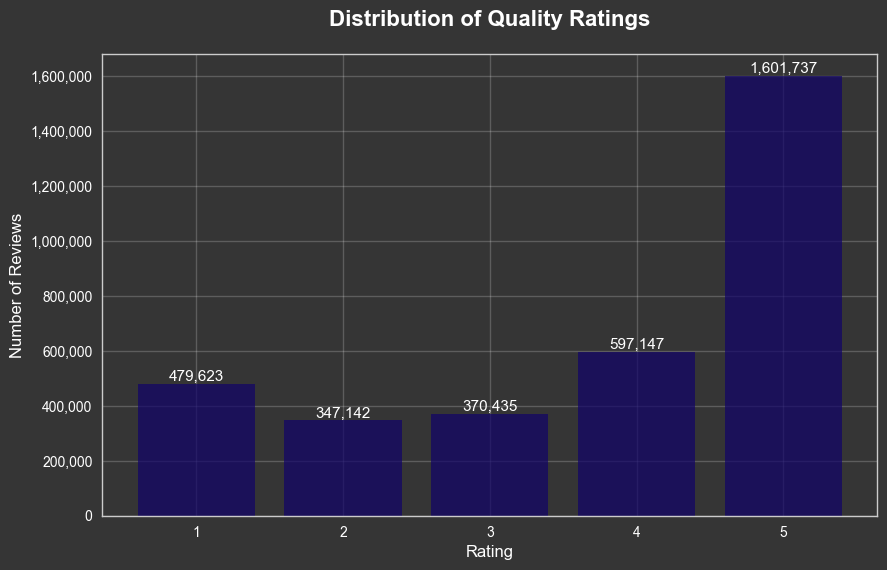

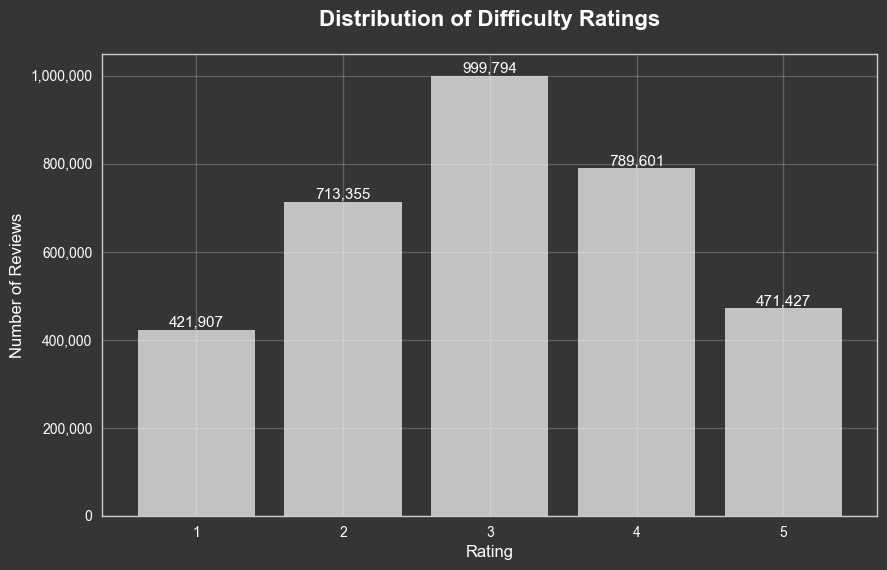

In [154]:
rating_counts = merged_df['quality_rating'].value_counts()

difficulty_counts = merged_df['difficulty_rating'].value_counts()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Plot bar chart
bars = plt.bar(rating_counts.index, rating_counts.values,
               color='#100269',
               alpha=0.7,
               width=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='white',
            fontsize=11)

# Configure plot
ax.set_title('Distribution of Quality Ratings',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax.set_xlabel('Rating', fontsize=12, color='white')
ax.set_ylabel('Number of Reviews', fontsize=12, color='white')

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='white')
ax.tick_params(colors='white')

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

# Create figure and axis for difficulty ratings
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#353535')
ax.set_facecolor('#353535')

# Plot bar chart
bars = plt.bar(difficulty_counts.index, difficulty_counts.values,
               color='#ffffff',
               alpha=0.7,
               width=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='white',
            fontsize=11)

# Configure plot
ax.set_title('Distribution of Difficulty Ratings',
             fontsize=16,
             pad=20,
             color='white',
             weight='bold')
ax.set_xlabel('Rating', fontsize=12, color='white')
ax.set_ylabel('Number of Reviews', fontsize=12, color='white')

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='white')
ax.tick_params(colors='white')

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))





In [158]:
def create_plot_template(data, x_col, y_col, title, y_label,
                        x_lim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01')),
                        y_lim=(2.5, 3.5), color='#bc1f1f'):
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Light mode colors
    fig.patch.set_facecolor('#dcdcdc')
    ax.set_facecolor('#dcdcdc')
    
    ax.plot(data[x_col], data[y_col],
            color=color,
            linewidth=2.5)
    ax.fill_between(data[x_col], data[y_col],
                    color=color,
                    alpha=0.2)
    
    ax.set_title(title,
                 fontsize=16,
                 pad=20,
                 color='#333333',
                 weight='bold')
    ax.set_xlabel('Date', fontsize=12, color='#333333')
    ax.set_ylabel(y_label, fontsize=12, color='#333333')
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid(True, linestyle='-', alpha=0.2, color='#666666')
    ax.tick_params(colors='#333333')
    
    return fig

def create_dual_plot_template(data1, data2, x_col, y_col1, y_col2, 
                            title1, title2, y_label, 
                            x_lim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2025-02-01')),
                            y_lim=(2.5, 3.5), color='#2196f3'):
    plt.style.use('seaborn-v0_8')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Light mode colors
    fig.patch.set_facecolor('#dcdcdc')
    ax1.set_facecolor('#dcdcdc')
    ax2.set_facecolor('#dcdcdc')
    
    for ax, data, y_col, title in [(ax1, data1, y_col1, title1), 
                                  (ax2, data2, y_col2, title2)]:
        ax.plot(data[x_col], data[y_col],
                color=color,
                linewidth=2.5)
        ax.fill_between(data[x_col], data[y_col],
                        color=color,
                        alpha=0.2)
        
        ax.set_title(title,
                     fontsize=16,
                     pad=20,
                     color='#333333',
                     weight='bold')
        ax.set_xlabel('Date', fontsize=12, color='#333333')
        ax.set_ylabel(y_label, fontsize=12, color='#333333')
        
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.grid(True, linestyle='-', alpha=0.2, color='#666666')
        ax.tick_params(colors='#333333')
    
    plt.subplots_adjust(hspace=0.3)
    return fig

def create_histogram_template(data, col, title, x_label, bins=30, color='#bc1f1f'):
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Light mode colors
    fig.patch.set_facecolor('#dcdcdc')
    ax.set_facecolor('#dcdcdc')
    
    plt.bar(data['datetime'].dt.year,
           data[col],
           color=color,
           alpha=0.7,
           width=0.8)
    
    ax.set_title(title,
                 fontsize=16,
                 pad=20,
                 color='#333333',
                 weight='bold')
    ax.set_xlabel(x_label, fontsize=12, color='#333333')
    ax.set_ylabel('Percentage', fontsize=12, color='#333333')
    
    ax.grid(True, linestyle='-', alpha=0.2, color='#666666')
    ax.tick_params(colors='#333333')
    
    return fig

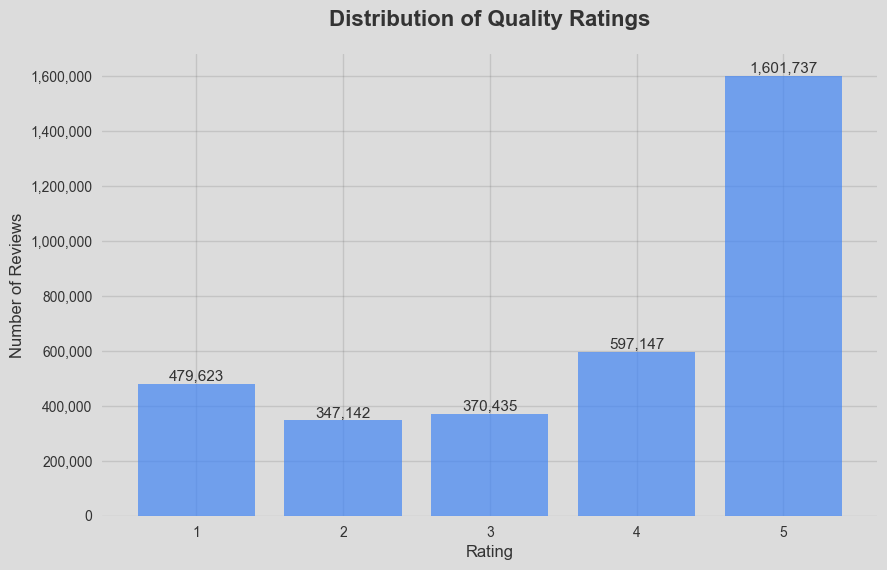

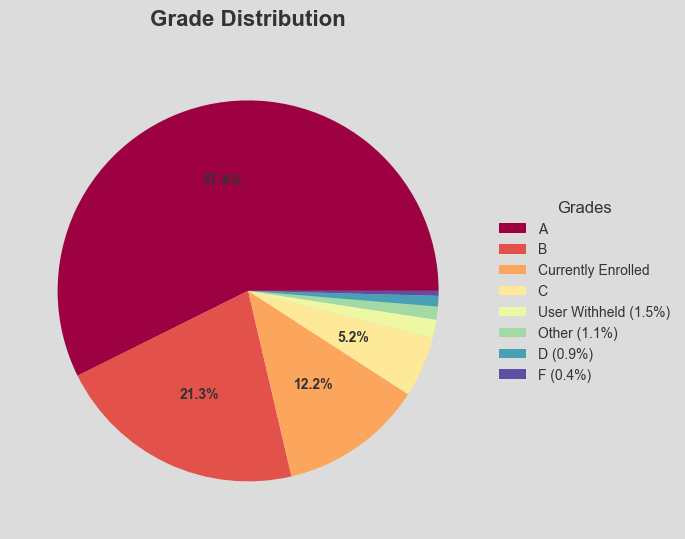

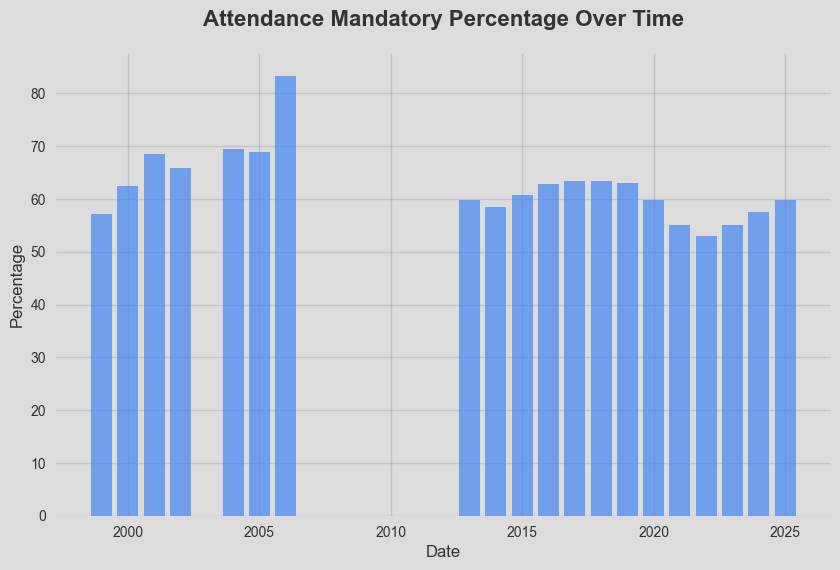

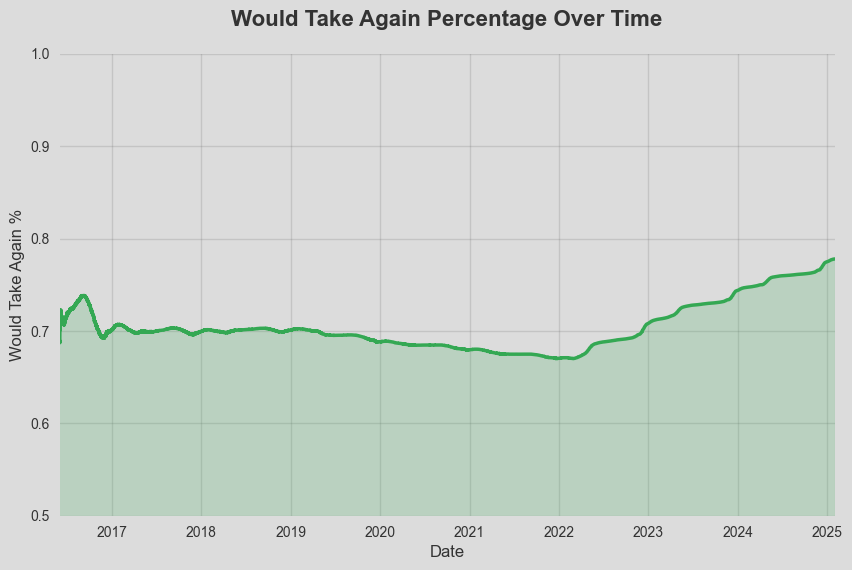

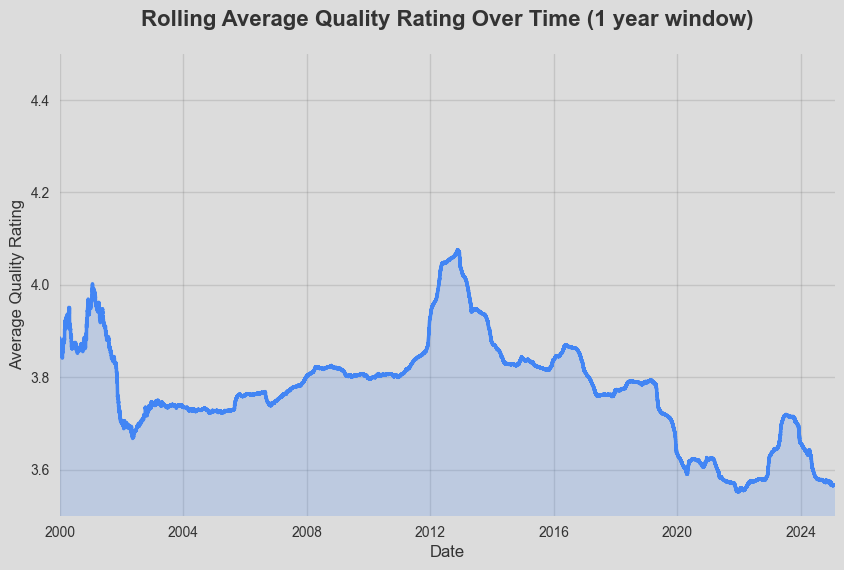

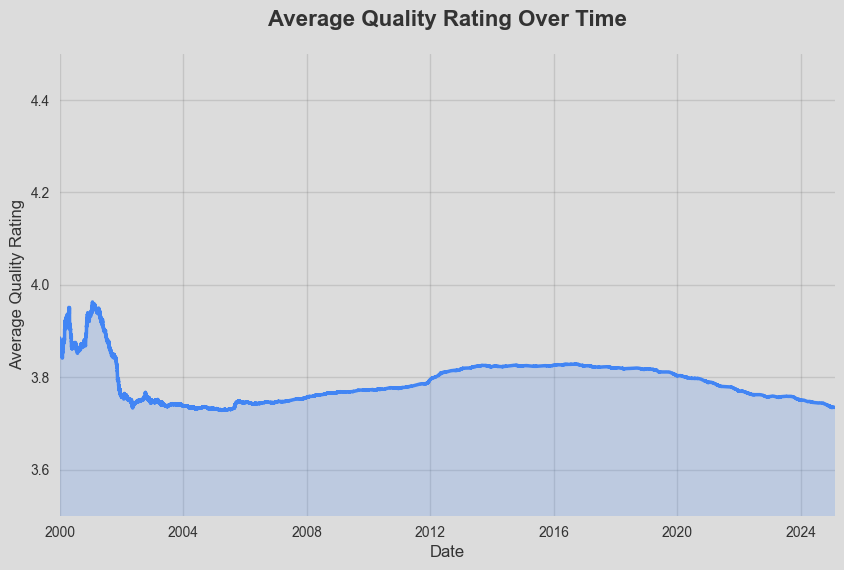

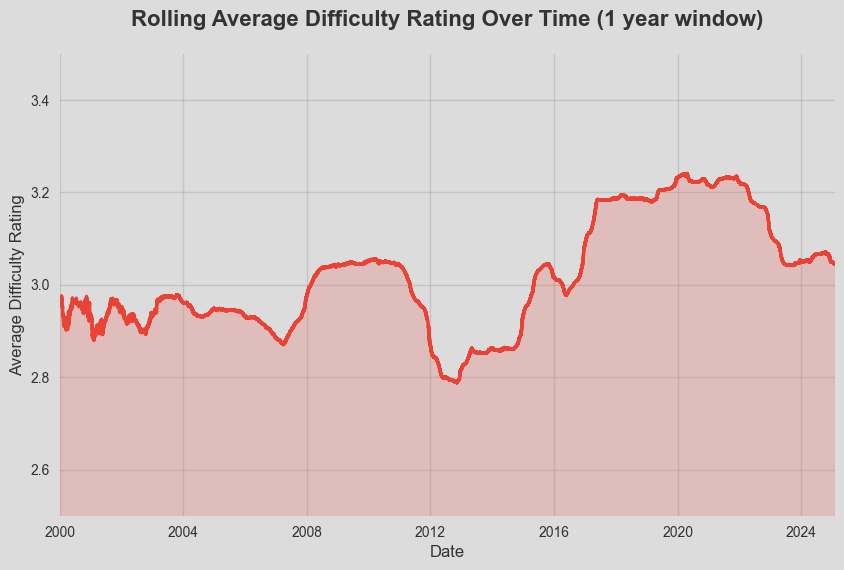

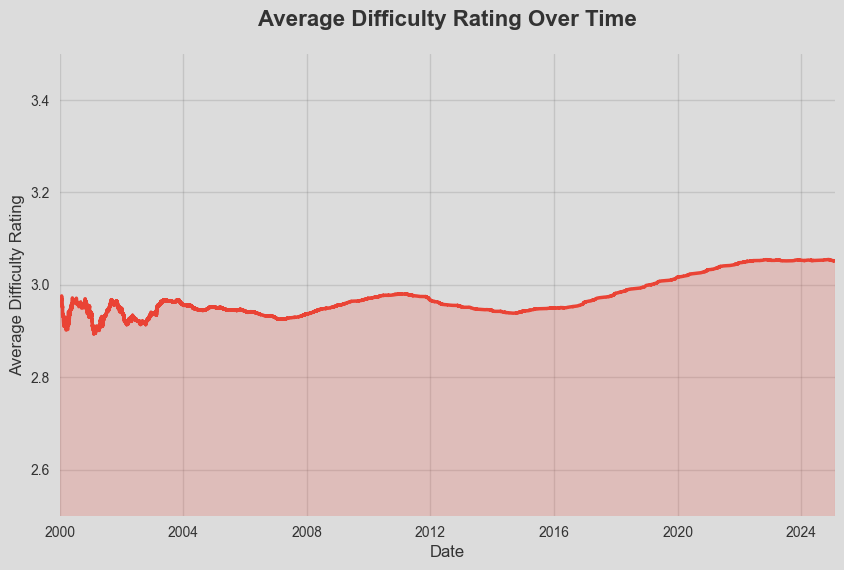

In [166]:
# 1. Quality Rating Distribution
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#dcdcdc')
ax.set_facecolor('#dcdcdc')

bars = plt.bar(rating_counts.index, rating_counts.values,
               color='#4285f4',
               alpha=0.7,
               width=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='#333333',
            fontsize=11)

ax.set_title('Distribution of Quality Ratings',
             fontsize=16,
             pad=20,
             color='#333333',
             weight='bold')
ax.set_xlabel('Rating', fontsize=12, color='#333333')
ax.set_ylabel('Number of Reviews', fontsize=12, color='#333333')
ax.grid(True, linestyle='-', alpha=0.2, color='#666666')
ax.tick_params(colors='#333333')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

# 2. Difficulty Rating Distribution
# (Same structure as above, but with color='#34a853')

# 3. Grade Distribution Pie Chart
fig, ax = plt.subplots(figsize=(8, 5.5))
fig.patch.set_facecolor('#dcdcdc')
ax.set_facecolor('#dcdcdc')

# Calculate percentages
pcts = grade_counts / grade_counts.sum() * 100

# Create pie chart
wedges, texts, autotexts = ax.pie(grade_counts,
                                 labels=grade_counts.index,
                                 autopct=make_autopct(pcts),
                                 textprops={'color': '#dcdcdc'},
                                 colors=plt.cm.Spectral(np.linspace(0, 1, len(grade_counts))))

# Style the plot
plt.setp(autotexts, size=10, weight="bold", color='#333333')

# Add title
ax.set_title('Grade Distribution',
             fontsize=16,
             pad=20,
             color='#333333',
             weight='bold')

# Add legend with percentages for small slices
legend_labels = [f'{grade} ({pct:.1f}%)' if pct < 2 else grade 
                for grade, pct in zip(grade_counts.index, pcts)]

legend = plt.legend(wedges, legend_labels,
          title="Grades",
          title_fontsize=12,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 10},
          labelcolor='#333333')
legend.get_title().set_color('#333333')

plt.tight_layout()

# 4. Reviews by Month
# (Same structure as first example, but with color='#fbbc05')

# 5. Reviews by Year
# (Same structure as first example, but with color='#ea4335')

# 6. Rating Tags Distribution
# (Same structure as first example, but with color='#34a853')

# 7. Attendance Mandatory Percentage
create_histogram_template(
    data=attendance_mandatory,
    col='attendance_mandatory_percentage',
    title='Attendance Mandatory Percentage Over Time',
    x_label='Date',
    bins=26,
    color='#4285f4'
)
plt.show()

# 8. Would Take Again Percentage
create_plot_template(
    data=would_take_again,
    x_col='datetime',
    y_col='would_take_again_percentage',
    title='Would Take Again Percentage Over Time',
    y_label='Would Take Again %',
    x_lim=(pd.Timestamp('2016-06-01'), pd.Timestamp('2025-02-01')),
    y_lim=(0.5, 1.0),
    color='#34a853'
)
plt.show()

# 9a. Rolling Average Quality Rating Over Time
create_plot_template(
    data=rolling_quality,
    x_col='datetime',
    y_col='rolling_avg_quality',
    title='Rolling Average Quality Rating Over Time (1 year window)',
    y_label='Average Quality Rating',
    y_lim=(3.5, 4.5),
    color='#4285f4'
)
plt.show()

# 9b. Average Quality Rating Over Time
create_plot_template(
    data=avg_quality,
    x_col='datetime',
    y_col='avg_quality', 
    title='Average Quality Rating Over Time',
    y_label='Average Quality Rating',
    y_lim=(3.5, 4.5),
    color='#4285f4'
)
plt.show()

# 10a. Rolling Average Difficulty Rating Over Time
create_plot_template(
    data=rolling_difficulty,
    x_col='datetime',
    y_col='rolling_avg_difficulty',
    title='Rolling Average Difficulty Rating Over Time (1 year window)',
    y_label='Average Difficulty Rating',
    y_lim=(2.5, 3.5),
    color='#ea4335'
)
plt.show()

# 10b. Average Difficulty Rating Over Time
create_plot_template(
    data=avg_difficulty,
    x_col='datetime',
    y_col='avg_difficulty',
    title='Average Difficulty Rating Over Time',
    y_label='Average Difficulty Rating', 
    y_lim=(2.5, 3.5),
    color='#ea4335'
)
plt.show()

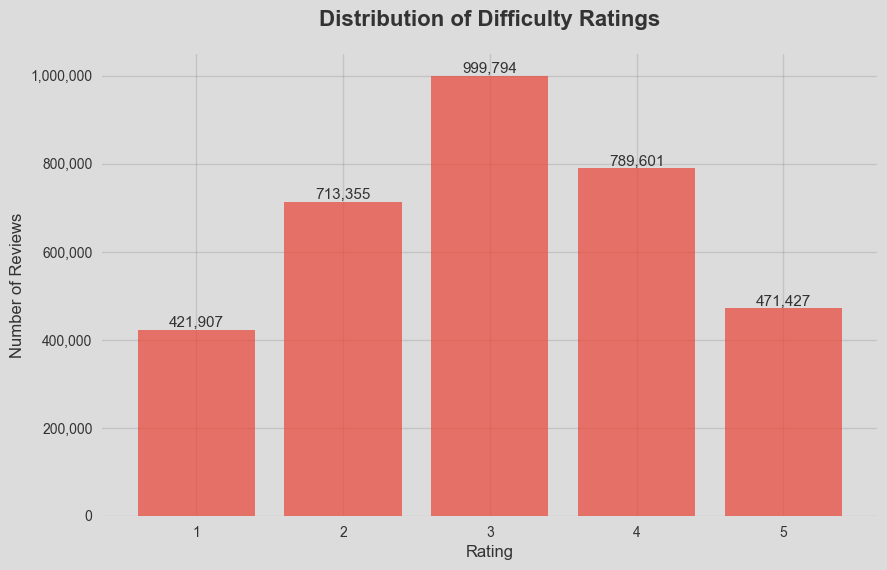

NameError: name 'tag_counts' is not defined

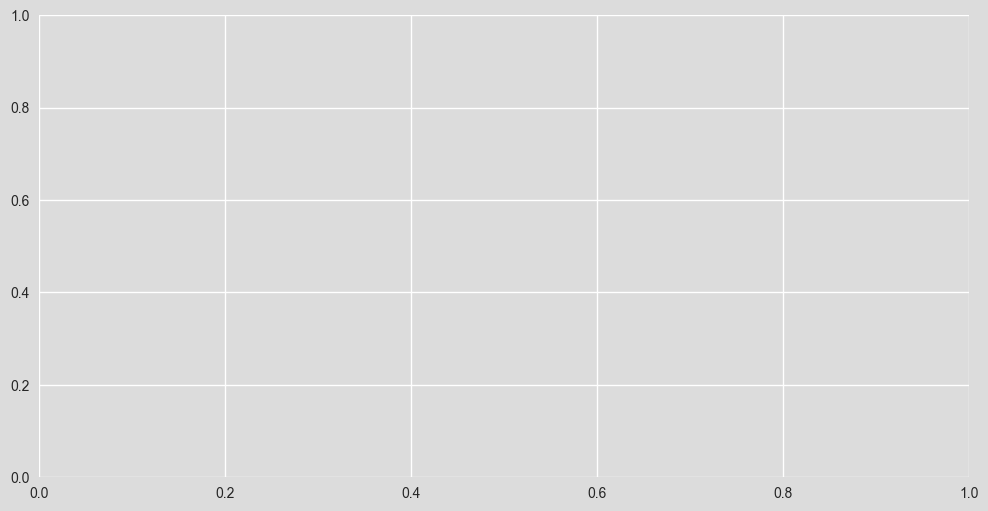

In [162]:
# 1. Difficulty Distribution
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#dcdcdc')
ax.set_facecolor('#dcdcdc')

bars = plt.bar(difficulty_counts.index, difficulty_counts.values,
               color='#ea4335',  # Google red
               alpha=0.7,
               width=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='#333333',
            fontsize=11)

ax.set_title('Distribution of Difficulty Ratings',
             fontsize=16,
             pad=20,
             color='#333333',
             weight='bold')
ax.set_xlabel('Rating', fontsize=12, color='#333333')
ax.set_ylabel('Number of Reviews', fontsize=12, color='#333333')
ax.grid(True, linestyle='-', alpha=0.2, color='#666666')
ax.tick_params(colors='#333333')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


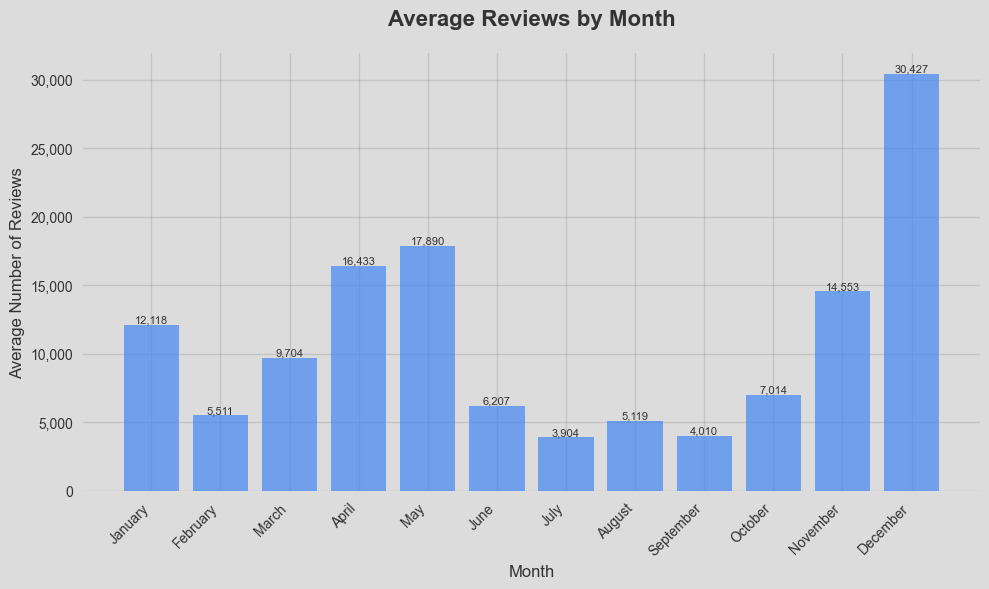

In [163]:
# Group reviews by month number and calculate average count
monthly_data = {}
for index, row in monthly_reviews.iterrows():
    month = row['month_year'].strftime('%B')  # Get month name
    if month not in monthly_data:
        monthly_data[month] = []
    monthly_data[month].append(row['count'])

# Calculate average count for each month
avg_monthly_data = {month: sum(counts)/len(counts) for month, counts in monthly_data.items()}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#dcdcdc')  # Changed from #353535
ax.set_facecolor('#dcdcdc')  # Changed from #353535

# Convert dictionary to lists for plotting
months = list(avg_monthly_data.keys())
counts = list(avg_monthly_data.values())

# Reorder months chronologically
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
counts = [avg_monthly_data[month] for month in month_order]

# Plot bar chart
bars = plt.bar(month_order, counts,
               color='#4285f4',  # Changed from #dade21
               alpha=0.7,
               width=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='#333333',  # Changed from white
            fontsize=8,
            rotation=0)

# Configure plot
ax.set_title('Average Reviews by Month',
             fontsize=16,
             pad=20,
             color='#333333',  # Changed from white
             weight='bold')
ax.set_xlabel('Month', fontsize=12, color='#333333')  # Changed from white
ax.set_ylabel('Average Number of Reviews', fontsize=12, color='#333333')  # Changed from white

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='#666666')  # Changed from white
ax.tick_params(colors='#333333')  # Changed from white
plt.xticks(rotation=45, ha='right')

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

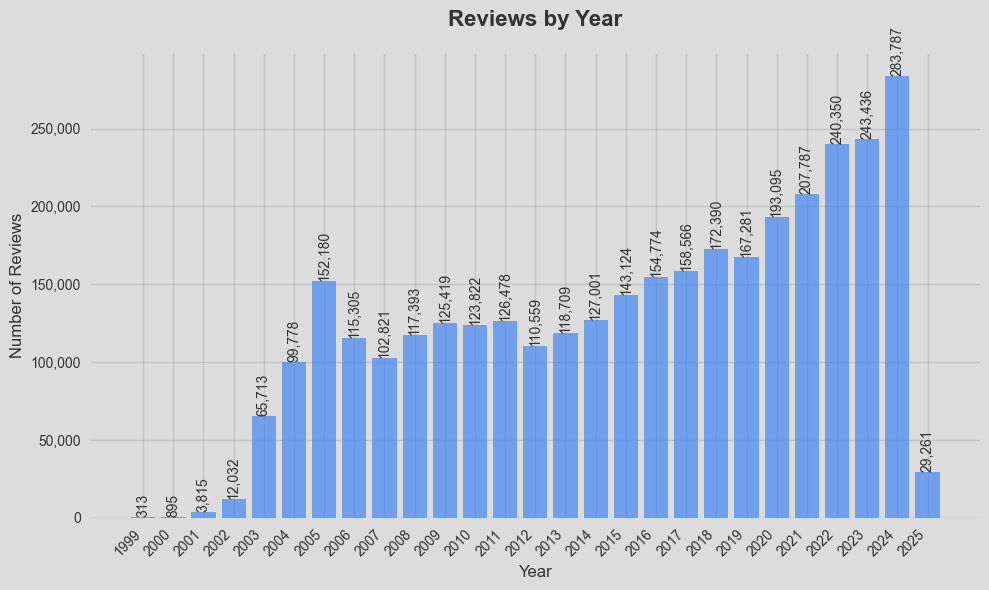

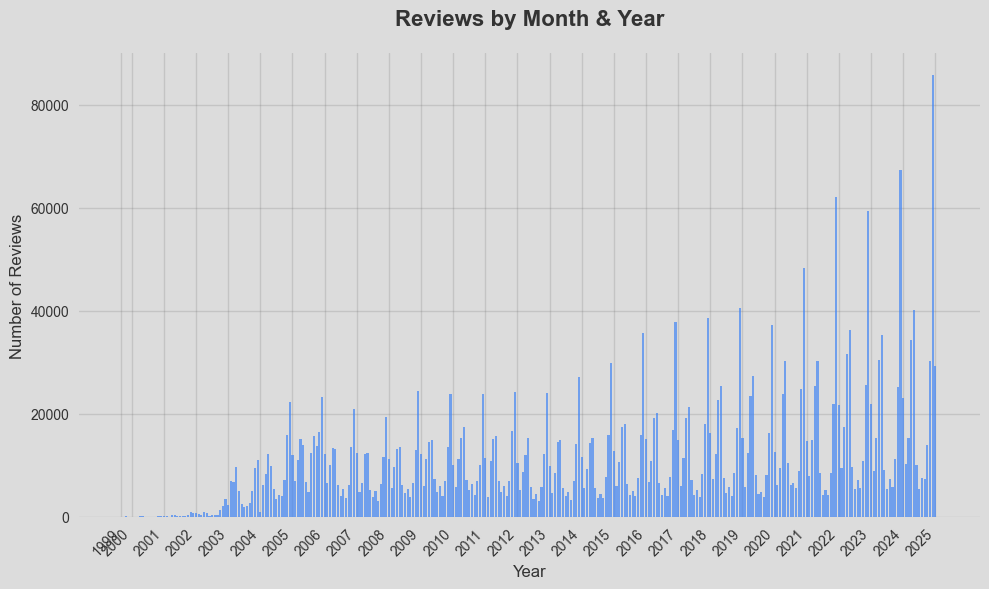

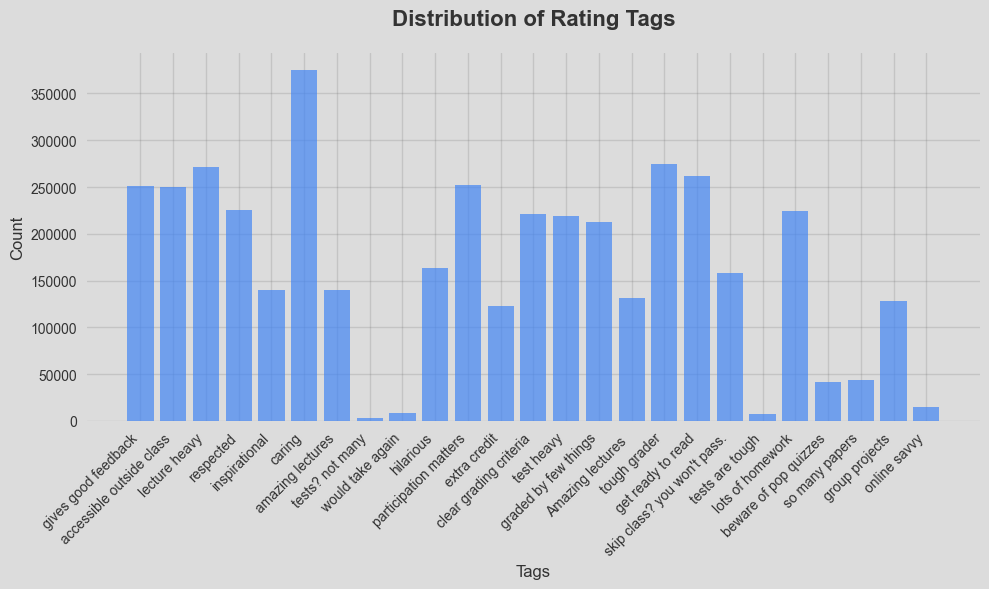

In [164]:


# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#dcdcdc')
ax.set_facecolor('#dcdcdc')

# Convert dictionary to lists for plotting
years = list(yearly_reviews.keys())
counts = list(yearly_reviews.values())

# Plot bar chart
bars = plt.bar(years, counts,
               color='#4285f4',  # Changed from #c53aae to Google blue
               alpha=0.7,
               width=0.8)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom',
            color='#333333',  # Changed from white to dark gray
            fontsize=10,
            rotation=90)

# Configure plot
ax.set_title('Reviews by Year',
             fontsize=16,
             pad=20,
             color='#333333',  # Changed from white to dark gray
             weight='bold')
ax.set_xlabel('Year', fontsize=12, color='#333333')  # Changed from white to dark gray
ax.set_ylabel('Number of Reviews', fontsize=12, color='#333333')  # Changed from white to dark gray

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='#666666')  # Changed from white to medium gray
ax.tick_params(colors='#333333')  # Changed from white to dark gray
plt.xticks(rotation=45, ha='right')

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

# Create figure and axis with minimal styling
plt.style.use('seaborn-v0_8-dark-palette')
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#dcdcdc')
ax.set_facecolor('#dcdcdc')

# Plot bar chart
plt.bar(range(len(monthly_reviews)), 
        monthly_reviews['count'],
        color='#4285f4',  # Changed from #47cde8 to Google blue
        alpha=0.7,
        width=0.8)

# Create labels for years only
years = monthly_reviews['month_year'].dt.year.astype(str)
xtick_positions = range(len(monthly_reviews))
unique_years = years.unique()
year_positions = [i for i, year in enumerate(years) if year in unique_years and years.iloc[i-1] != year]
year_labels = [years[i] for i in year_positions]

# Configure plot
ax.set_title('Reviews by Month & Year',
             fontsize=16,
             pad=20,
             color='#333333',  # Changed from white to dark gray
             weight='bold')
ax.set_xlabel('Year', fontsize=12, color='#333333')  # Changed from white to dark gray
ax.set_ylabel('Number of Reviews', fontsize=12, color='#333333')  # Changed from white to dark gray

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='#666666')  # Changed from white to medium gray
ax.tick_params(colors='#333333')  # Changed from white to dark gray
plt.xticks(year_positions, year_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Create figure and axis with minimal styling
plt.style.use('seaborn-v0_8-dark-palette')
fig, ax = plt.subplots(figsize=(10, 6))

# Set background color
fig.patch.set_facecolor('#dcdcdc')
ax.set_facecolor('#dcdcdc')

# Plot bar chart using the data
plt.bar(Overall_tags.keys(), 
        Overall_tags.values(),
        color='#4285f4',  # Changed from #2aeb81 to Google blue
        alpha=0.7,
        width=0.8)

# Configure plot
ax.set_title('Distribution of Rating Tags',
             fontsize=16,
             pad=20,
             color='#333333',  # Changed from white to dark gray
             weight='bold')
ax.set_xlabel('Tags', fontsize=12, color='#333333')  # Changed from white to dark gray
ax.set_ylabel('Count', fontsize=12, color='#333333')  # Changed from white to dark gray

# Set axis styling
ax.grid(True, linestyle='-', alpha=0.2, color='#666666')  # Changed from white to medium gray
ax.tick_params(colors='#333333')  # Changed from white to dark gray
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [165]:
# Print number of unique professors and total reviews
print(f"Number of unique professors: {merged_df['pid'].nunique():,}")
print(f"Total number of reviews: {len(merged_df):,}")


Number of unique professors: 251,237
Total number of reviews: 3,396,084
